# Analysis of the Reddit Dataset using different variants of Graph Neural Networks

This code is generated by combining different sources we found while learning about Graph Neural Networks. Many of the examples available over the internet are coded in Pytorch Geometric hence we have also taken this approach. Our project is mainly referenced from the following sources:
1. [Tutorials Provided on Pytorch Official Website](https://pytorch-geometric.readthedocs.io/en/2.5.0/get_started/colabs.html)
2. [Standford CS224W Course on Machine Learning with Graphs](https://web.stanford.edu/class/cs224w/)
3. [Dataset is used from Pyg which is originally referred a paper](https://arxiv.org/abs/1706.02216)


In [ ]:
# Install the addtional packages required for PyG

!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html

!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html

!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=3663909 sha256=b92a3e4ee18c453643d211a15a40364735aa35694c77387dbd53dc2303ab3170
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built torch-scatter
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=2738050 sha256=08000b215646d2aca8e98cc42ac43c7a72a63e14af3622b4c55abcfe2d691309
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d257b4b4ea91b548b984a341ed3b8f38c


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jun  5 17:38:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   43C    P8              11W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#### Importing the required modules and functions from Pytorch Geometric and Pytorch

In [ ]:
import copy
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import networkx as nx

import torch
import torch.nn.functional as F

from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import GCNConv, SAGEConv, MLP, GATConv, global_add_pool
from torch_geometric.utils import to_networkx

ModuleNotFoundError: No module named 'torch_geometric'

In [ ]:
# Setting up the GPU device

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Loading the dataset available in Pyg

In [ ]:
from torch_geometric.datasets import Reddit

path = '/content/Reddit'
dataset = Reddit(path)

Extracting /content/Reddit/raw/reddit.zip
Processing...
Done!


#### Exploring the graph dataset, it's properties and doing some transformations

In [ ]:
print(f'Dataset: {dataset}:')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: Reddit():
Number of graphs: 1
Number of features: 602
Number of classes: 41


This dataset is available in the PyG datasets modules. It was introduced and collected for the [Inductive Representation Learning on Large Graphs](https://arxiv.org/abs/1706.02216). Each node represents a post. Each edge represents the same user commenting on both the posts i.e nodes. Each class label represents the "Sub Redit" community the post i.e node belongs to. The task is to classify a node in one of the "Sub-Reddit" community. Let's explore more !

In [ ]:
# The first part of the dataset object is the graph structure, which is stored in the data attribute.
data = dataset[0].to(device, 'x', 'y')

In [ ]:
# Exploring the data object of the graph
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of validation nodes: {data.val_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[232965, 602], edge_index=[2, 114615892], y=[232965], train_mask=[232965], val_mask=[232965], test_mask=[232965])
Number of nodes: 232965
Number of edges: 114615892
Average node degree: 491.99
Number of training nodes: 153431
Number of validation nodes: 23831
Number of test nodes: 55703
Training node label rate: 0.66
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [ ]:
# A glimpse of the node features
print(data.x[0])

tensor([ 1.2334e+00,  9.0430e+00, -9.2328e-01,  1.0542e+00, -1.1125e+00,
        -2.0630e-02,  4.2540e-02,  2.1520e+00, -9.0830e-01,  7.1384e-01,
         1.1512e+00, -1.2357e+00,  1.1699e+00, -1.2657e+00, -8.6435e-01,
         3.5655e-01, -1.0509e+00,  1.3829e-01, -2.8985e-01, -4.5366e-01,
        -1.7766e-01,  7.8746e-01, -1.2298e+00, -9.3718e-01, -2.8484e-02,
        -6.2839e-01, -1.5315e-01,  4.0115e-02,  8.6607e-01, -3.5893e-01,
        -9.7886e-02,  1.0300e+00, -1.5091e-01, -1.1921e+00,  7.9493e-01,
         3.7253e-01,  1.7400e-01, -2.5684e-01, -1.2256e+00, -3.7878e-01,
        -1.3944e+00,  4.4133e-01,  8.8975e-01,  7.1985e-02,  1.5196e+00,
         1.2643e+00,  3.3659e-01, -8.5132e-01,  1.6793e+00, -5.1868e-01,
         1.9735e+00,  1.2463e+00,  4.9956e-01, -7.1537e-01, -3.5420e-01,
        -1.8007e+00,  2.3424e+00, -7.6472e-01,  6.8058e-01,  4.0231e-01,
        -9.0589e-01,  9.3627e-01, -3.0335e-01,  1.0683e+00,  1.2881e-01,
        -5.6879e-01, -7.4037e-01,  1.5159e+00,  1.0

In [ ]:
# A glimpse of the node labels
print(data.y.unique())

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40])


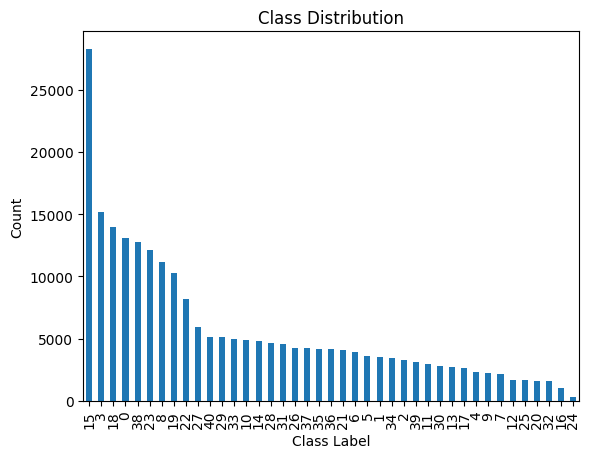

In [ ]:
# Count of each class in the dataset
counts = torch.bincount(data.y).tolist()

# Create a DataFrame
df = pd.DataFrame({
    'Class Label': range(len(counts)),
    'Count': counts
})

# Make a bar plot with acending order
df = df.sort_values('Count', ascending=False)
df.plot(x='Class Label', y='Count', kind='bar', legend=False)
plt.title('Class Distribution')
plt.ylabel('Count')
plt.xlabel('Class Label')
plt.show()

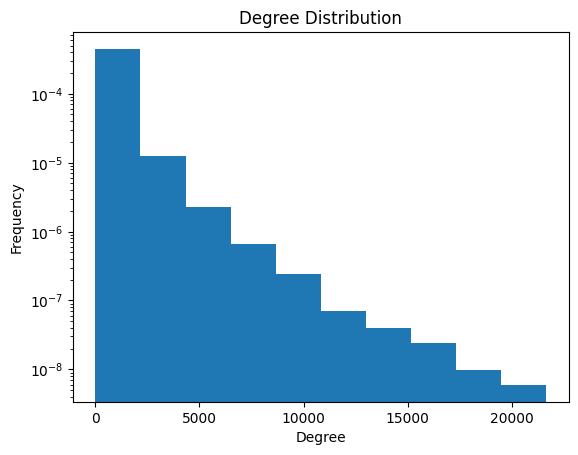

In [ ]:
deg = data.edge_index[0].bincount()

# Plot the degree distribution using density plot
plt.hist(deg.cpu().numpy(), density=True, log=True)
plt.title('Degree Distribution')
plt.ylabel('Frequency')
plt.xlabel('Degree')
plt.show()

As the dataset is huge i.e 232965 nodes. A huge compute power will be required to train the whole graph. Hence, we will make use of the data loader utility from pytorch to convert our huge graph in mini-batch and train the algorithm accordingly.

Setting up the hyper parameters for data loader. One interesting point is that data loader hyper parameters also effect the final output.

In [ ]:
# Num_Workers is the number of processes to use for data loading. persistent_workers is a boolean flag to enable persistent workers which enables the worker processes to persist for multiple data loading iterations.
dataLoaderArguments = {'batch_size': 1024, 'num_workers': 2, 'persistent_workers': True}

In [ ]:
# NeighborLoader is a data loader that samples neighbors for each node in the graph and returns them in a batch.

# For training, we sample 25 neighbors for each node and 10 neighbors for each node for validation and testing. Again, this is a hyperparameter that can be tuned.
train_loader = NeighborLoader(data, input_nodes=data.train_mask,
                              num_neighbors=[25, 10], shuffle=True, **dataLoaderArguments)

subgraph_loader = NeighborLoader(copy.copy(data), input_nodes=None,
                                 num_neighbors=[-1], shuffle=False, **dataLoaderArguments)


del subgraph_loader.data.x, subgraph_loader.data.y
subgraph_loader.data.num_nodes = data.num_nodes
subgraph_loader.data.n_id = torch.arange(data.num_nodes)

/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


Some helper functions

In [ ]:
# A simple helper function to visualize the graph
def visualize_graph(data):
    G = to_networkx(data, to_undirected=True)
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, with_labels=False, node_size=30, node_color='black')
    plt.show()

# A simple helper function to visualize the node embeddings
def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(10,10))
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

#### An implementation of a GCN (Graph Convolution Network)

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args):
        super(GCN, self).__init__()

        self.num_layers = args.num_layers
        self.dropout = args.dropout

        self.convs = torch.nn.ModuleList(
            [GCNConv(input_dim, hidden_dim)]
            + [GCNConv(hidden_dim, hidden_dim) for _ in range(self.num_layers - 2)]
            + [GCNConv(hidden_dim, output_dim)]
        )
        self.bns = torch.nn.ModuleList(torch.nn.BatchNorm1d(hidden_dim) for _ in range(self.num_layers - 1))

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < len(self.convs) - 1:
                x = self.bns[i](x)
                x = x.relu_()
                x = F.dropout(x, p=self.dropout, training=self.training)
        return x

    """ This function will be invoked during the testing phase to obtain the node embeddings and the final output of the model. In the code above, we can see that we loaded the subgraph_loader
    as well. This is because we need to pass the entire graph to the model to obtain the embeddings. The subgraph_loader will be used to pass the entire graph to the model in batches for each layer.
    Lastly, we concatenate the embeddings obtained from each layer and return them. The output y_hat will be calculated using this."""
    @torch.no_grad()
    def inference(self, x_all, subgraph_loader):
        pbar = tqdm(total=len(subgraph_loader.dataset) * len(self.convs), position = 0, leave = True)
        pbar.set_description('Evaluating')
        for i, conv in enumerate(self.convs):
            xs = []
            for batch in subgraph_loader:
                x = x_all[batch.n_id.to(x_all.device)].to(device)
                x = conv(x, batch.edge_index.to(device))
                if i < len(self.convs) - 1:
                    x = x.relu_()
                xs.append(x[:batch.batch_size].cpu())
                pbar.update(batch.batch_size)
            x_all = torch.cat(xs, dim=0)
        pbar.close()
        return x_all

#### An implementation of a GraphSAGE (Graph Sample and Aggregate)

In [ ]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args):
        super().__init__()

        self.dropout = args.dropout
        self.num_layers = args.num_layers

        self.convs = torch.nn.ModuleList(
            [SAGEConv(input_dim, hidden_dim)]
            + [SAGEConv(hidden_dim, hidden_dim) for _ in range(self.num_layers - 2)]
            + [SAGEConv(hidden_dim, output_dim)]
        )
        self.bns = torch.nn.ModuleList(torch.nn.BatchNorm1d(hidden_dim) for _ in range(self.num_layers - 1))

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < len(self.convs) - 1:
                x = self.bns[i](x)
                x = x.relu_()
                x = F.dropout(x, p=self.dropout, training=self.training)
        return x

    """ This function will be invoked during the testing phase to obtain the node embeddings and the final output of the model. In the code above, we can see that we loaded the subgraph_loader
    as well. This is because we need to pass the entire graph to the model to obtain the embeddings. The subgraph_loader will be used to pass the entire graph to the model in batches for each layer.
    Lastly, we concatenate the embeddings obtained from each layer and return them. The output y_hat will be calculated using this."""
    @torch.no_grad()
    def inference(self, x_all, subgraph_loader):
        pbar = tqdm(total=len(subgraph_loader.dataset) * len(self.convs), position = 0, leave = True)
        pbar.set_description('Evaluating')
        for i, conv in enumerate(self.convs):
            xs = []
            for batch in subgraph_loader:
                x = x_all[batch.n_id.to(x_all.device)].to(device)
                x = conv(x, batch.edge_index.to(device))
                if i < len(self.convs) - 1:
                    x = x.relu_()
                xs.append(x[:batch.batch_size].cpu())
                pbar.update(batch.batch_size)
            x_all = torch.cat(xs, dim=0)
        pbar.close()
        return x_all

#### An implementation of a GAT (Graph Attention Network)

In [ ]:
class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args):
        super().__init__()

        self.heads = args.heads
        self.dropout = args.dropout
        self.num_layers = args.num_layers

        self.convs = torch.nn.ModuleList(
            [GATConv(input_dim, hidden_dim, heads=self.heads, dropout=self.dropout)]
            + [GATConv(hidden_dim * self.heads, hidden_dim,heads=self.heads, dropout=self.dropout) for _ in range(self.num_layers - 2)]
            + [GATConv(hidden_dim*self.heads, output_dim, heads=1, concat=False, dropout=self.dropout)]
        )
        self.bns = torch.nn.ModuleList(torch.nn.BatchNorm1d(hidden_dim*self.heads) for _ in range(self.num_layers - 1))

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < len(self.convs) - 1:
                x = self.bns[i](x)
                x = x.relu_()
                x = F.dropout(x, p=self.dropout, training=self.training)
        return x

    """ This function will be invoked during the testing phase to obtain the node embeddings and the final output of the model. In the code above, we can see that we loaded the subgraph_loader
    as well. This is because we need to pass the entire graph to the model to obtain the embeddings. The subgraph_loader will be used to pass the entire graph to the model in batches for each layer.
    Lastly, we concatenate the embeddings obtained from each layer and return them. The output y_hat will be calculated using this."""
    @torch.no_grad()
    def inference(self, x_all, subgraph_loader):
        pbar = tqdm(total=len(subgraph_loader.dataset) * len(self.convs), position = 0, leave = True)
        pbar.set_description('Evaluating')
        for i, conv in enumerate(self.convs):
            xs = []
            for batch in subgraph_loader:
                x = x_all[batch.n_id.to(x_all.device)].to(device)
                x = conv(x, batch.edge_index.to(device))
                if i < len(self.convs) - 1:
                    x = x.relu_()
                xs.append(x[:batch.batch_size].cpu())
                pbar.update(batch.batch_size)
            x_all = torch.cat(xs, dim=0)
        pbar.close()
        return x_all

NameError: name 'torch' is not defined

#### Now, we will define a hyper parameters list, train one model to check if everything is working. Also, defining the train and test functions.

In [ ]:
def train(epoch):
    model.train()

    pbar = tqdm(total=int(len(train_loader.dataset)), position = 0, leave = True)
    pbar.set_description(f'Epoch {epoch:02d}')

    total_loss = total_correct = total_examples = 0
    for batch in train_loader:
        optimizer.zero_grad()
        y = batch.y[:batch.batch_size]
        y_hat = model(batch.x, batch.edge_index.to(device))[:batch.batch_size]
        loss = F.cross_entropy(y_hat, y)
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * batch.batch_size
        total_correct += int((y_hat.argmax(dim=-1) == y).sum())
        total_examples += batch.batch_size
        pbar.update(batch.batch_size)
    pbar.close()

    return total_loss / total_examples, total_correct / total_examples


@torch.no_grad()
def test():
    model.eval()
    y_hat = model.inference(data.x, subgraph_loader).argmax(dim=-1)
    y = data.y.to(y_hat.device)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        accs.append(int((y_hat[mask] == y[mask]).sum()) / int(mask.sum()))
    return accs

In [ ]:
hyperparameter = {
    'batch_size': 1024,
    'num_layers': 3,
    'heads': 2,
    'hidden_dim': 256,
    'dropout': 0.5,
    'epochs': 5,
    'opt': 'adam',
    'weight_decay': 5e-3,
    'lr': 0.01
}

# Simple helper function to create a model instance based on the model_name argument passed to it. The model_name argument can be either 'GCN', 'GraphSAGE', or 'GAT'.
class helperclass(object):
    def __init__(self, d):
        self.__dict__ = d

hyperparameter = helperclass(hyperparameter)


Training a simple GCN to check if everything is running smoothly

In [ ]:
model = GAT(dataset.num_features, hyperparameter.hidden_dim, dataset.num_classes, hyperparameter).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameter.lr, weight_decay=hyperparameter.weight_decay)

epoch = 1
# Start training
loss, acc = train(epoch)
print(f'Epoch {epoch:02d}, Loss: {loss:.4f}, Approx. Train: {acc:.4f}')
train_acc, val_acc, test_acc = test()
print(f'Epoch: {epoch:02d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

NameError: name 'GAT' is not defined

####Now, defining a set of hyper parameters, model list and a dict to store all the results which will be used to train the three models.

In [ ]:
hyperparameter = {
    'batch_size': [1024],
    'num_layers': [2,3],
    'heads': [2,3],
    'hidden_dim': [256,512],
    'dropout': [0.5],
    'weight_decay': [5e-3],
    'lr': [0.01],
    'opt': ['adam'],
    'epochs': [5]
}

models = ['GCN', 'GraphSAGE', 'GAT']
results = {}

In [ ]:
# Define one model at a time, train it, and evaluate it on the test set. We will store the results in a dictionary for each model.
for model_name in models:
    results[model_name] = {}
    for batch_size in hyperparameter['batch_size']:
        for num_layers in hyperparameter['num_layers']:
            for heads in hyperparameter['heads']:
                for hidden_dim in hyperparameter['hidden_dim']:
                    for dropout in hyperparameter['dropout']:
                        for epochs in hyperparameter['epochs']:
                            for opt in hyperparameter['opt']:

                                hyperparameter_iter = {
                                    'batch_size': batch_size,
                                    'num_layers': num_layers,
                                    'heads': heads,
                                    'hidden_dim': hidden_dim,
                                    'dropout': dropout,
                                    'epochs': epochs,
                                    'opt': opt,
                                    'weight_decay': 5e-3,
                                    'lr': 0.01
                                }

                                hyperparameter_used = helperclass(hyperparameter_iter)

                                if model_name == 'GCN':
                                    model = GCN(dataset.num_features, hyperparameter_used.hidden_dim, dataset.num_classes, hyperparameter_used).to(device)
                                elif model_name == 'GraphSAGE':
                                    model = GraphSAGE(dataset.num_features, hyperparameter_used.hidden_dim, dataset.num_classes, hyperparameter_used).to(device)
                                elif model_name == 'GAT':
                                    model = GAT(dataset.num_features, hyperparameter_used.hidden_dim, dataset.num_classes, hyperparameter_used).to(device)

                                optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameter_used.lr, weight_decay=hyperparameter_used.weight_decay)

                                key = f'batch_size_{batch_size}_num_layers_{num_layers}_heads_{heads}_hidden_dim_{hidden_dim}_dropout_{dropout}_opt_{opt}'
                                results[model_name][key] = {
                                    'loss': [],
                                    'train_acc': [],
                                    'val_acc': [],
                                    'test_acc': []
                                }

                                for epoch in range(1, hyperparameter_used.epochs+1):
                                    loss, acc = train(epoch)
                                    print(f'Epoch {epoch:02d}, Train Loss: {loss:.4f}, Train Acc: {acc:.4f}, Model: {model_name}, '
                                          f'Batch Size: {batch_size}, Num Layers: {num_layers}, Heads: {heads}, Hidden Dim: {hidden_dim}, Dropout: {dropout}, '
                                          f'Epochs: {epochs}, Opt: {opt}')

                                    access = []
                                    access = test()
                                    print(f'Epoch: {epoch:02d}, Train Accuracy: {access[0]:.4f}, Val Accuracy: {access[1]:.4f}, Test Accuracy: {access[2]:.4f}')

                                    results[model_name][key]['loss'].append(loss)
                                    results[model_name][key]['train_acc'].append(acc)
                                    results[model_name][key]['val_acc'].append(access[1])
                                    results[model_name][key]['test_acc'].append(access[2])

Epoch 01: 100%|██████████| 153431/153431 [00:35<00:00, 4262.48it/s]


Epoch 01, Train Loss: 0.5098, Train Acc: 0.8898, Model: GCN, Batch Size: 1024, Num Layers: 2, Heads: 2, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:29<00:00, 15581.65it/s]


Epoch: 01, Train Accuracy: 0.8707, Val Accuracy: 0.8782, Test Accuracy: 0.8769


Epoch 02: 100%|██████████| 153431/153431 [00:35<00:00, 4312.58it/s]


Epoch 02, Train Loss: 0.4190, Train Acc: 0.9106, Model: GCN, Batch Size: 1024, Num Layers: 2, Heads: 2, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:29<00:00, 15861.01it/s]


Epoch: 02, Train Accuracy: 0.8652, Val Accuracy: 0.8757, Test Accuracy: 0.8741


Epoch 03: 100%|██████████| 153431/153431 [00:35<00:00, 4301.13it/s]


Epoch 03, Train Loss: 0.4190, Train Acc: 0.9097, Model: GCN, Batch Size: 1024, Num Layers: 2, Heads: 2, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:29<00:00, 15849.20it/s]


Epoch: 03, Train Accuracy: 0.8150, Val Accuracy: 0.8257, Test Accuracy: 0.8269


Epoch 04: 100%|██████████| 153431/153431 [00:35<00:00, 4305.87it/s]


Epoch 04, Train Loss: 0.4186, Train Acc: 0.9100, Model: GCN, Batch Size: 1024, Num Layers: 2, Heads: 2, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:29<00:00, 15889.84it/s]


Epoch: 04, Train Accuracy: 0.8702, Val Accuracy: 0.8789, Test Accuracy: 0.8755


Epoch 05: 100%|██████████| 153431/153431 [00:35<00:00, 4301.28it/s]


Epoch 05, Train Loss: 0.4226, Train Acc: 0.9093, Model: GCN, Batch Size: 1024, Num Layers: 2, Heads: 2, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:29<00:00, 15688.39it/s]


Epoch: 05, Train Accuracy: 0.8844, Val Accuracy: 0.8901, Test Accuracy: 0.8893


Epoch 01: 100%|██████████| 153431/153431 [00:36<00:00, 4241.16it/s]


Epoch 01, Train Loss: 0.5071, Train Acc: 0.8908, Model: GCN, Batch Size: 1024, Num Layers: 2, Heads: 2, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:49<00:00, 9501.13it/s]


Epoch: 01, Train Accuracy: 0.8711, Val Accuracy: 0.8782, Test Accuracy: 0.8789


Epoch 02: 100%|██████████| 153431/153431 [00:36<00:00, 4255.15it/s]


Epoch 02, Train Loss: 0.4214, Train Acc: 0.9116, Model: GCN, Batch Size: 1024, Num Layers: 2, Heads: 2, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:49<00:00, 9478.65it/s]


Epoch: 02, Train Accuracy: 0.8790, Val Accuracy: 0.8866, Test Accuracy: 0.8860


Epoch 03: 100%|██████████| 153431/153431 [00:36<00:00, 4243.58it/s]


Epoch 03, Train Loss: 0.4231, Train Acc: 0.9101, Model: GCN, Batch Size: 1024, Num Layers: 2, Heads: 2, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:49<00:00, 9505.59it/s]


Epoch: 03, Train Accuracy: 0.8286, Val Accuracy: 0.8397, Test Accuracy: 0.8389


Epoch 04: 100%|██████████| 153431/153431 [00:36<00:00, 4227.14it/s]


Epoch 04, Train Loss: 0.4218, Train Acc: 0.9100, Model: GCN, Batch Size: 1024, Num Layers: 2, Heads: 2, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:49<00:00, 9442.53it/s]


Epoch: 04, Train Accuracy: 0.8365, Val Accuracy: 0.8477, Test Accuracy: 0.8468


Epoch 05: 100%|██████████| 153431/153431 [00:36<00:00, 4261.72it/s]


Epoch 05, Train Loss: 0.4223, Train Acc: 0.9090, Model: GCN, Batch Size: 1024, Num Layers: 2, Heads: 2, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:48<00:00, 9514.06it/s]


Epoch: 05, Train Accuracy: 0.8542, Val Accuracy: 0.8623, Test Accuracy: 0.8631


Epoch 01: 100%|██████████| 153431/153431 [00:35<00:00, 4263.21it/s]


Epoch 01, Train Loss: 0.5036, Train Acc: 0.8927, Model: GCN, Batch Size: 1024, Num Layers: 2, Heads: 3, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:29<00:00, 15817.85it/s]


Epoch: 01, Train Accuracy: 0.8643, Val Accuracy: 0.8732, Test Accuracy: 0.8729


Epoch 02: 100%|██████████| 153431/153431 [00:36<00:00, 4246.99it/s]


Epoch 02, Train Loss: 0.4206, Train Acc: 0.9106, Model: GCN, Batch Size: 1024, Num Layers: 2, Heads: 3, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:29<00:00, 15775.92it/s]


Epoch: 02, Train Accuracy: 0.8630, Val Accuracy: 0.8721, Test Accuracy: 0.8718


Epoch 03: 100%|██████████| 153431/153431 [00:35<00:00, 4283.09it/s]


Epoch 03, Train Loss: 0.4161, Train Acc: 0.9109, Model: GCN, Batch Size: 1024, Num Layers: 2, Heads: 3, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:29<00:00, 15749.70it/s]


Epoch: 03, Train Accuracy: 0.8518, Val Accuracy: 0.8603, Test Accuracy: 0.8589


Epoch 04: 100%|██████████| 153431/153431 [00:35<00:00, 4292.62it/s]


Epoch 04, Train Loss: 0.4195, Train Acc: 0.9101, Model: GCN, Batch Size: 1024, Num Layers: 2, Heads: 3, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:29<00:00, 15763.58it/s]


Epoch: 04, Train Accuracy: 0.8709, Val Accuracy: 0.8794, Test Accuracy: 0.8807


Epoch 05: 100%|██████████| 153431/153431 [00:35<00:00, 4286.93it/s]


Epoch 05, Train Loss: 0.4209, Train Acc: 0.9092, Model: GCN, Batch Size: 1024, Num Layers: 2, Heads: 3, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:29<00:00, 15806.24it/s]


Epoch: 05, Train Accuracy: 0.8765, Val Accuracy: 0.8849, Test Accuracy: 0.8850


Epoch 01: 100%|██████████| 153431/153431 [00:36<00:00, 4261.18it/s]


Epoch 01, Train Loss: 0.5150, Train Acc: 0.8899, Model: GCN, Batch Size: 1024, Num Layers: 2, Heads: 3, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:49<00:00, 9493.74it/s]


Epoch: 01, Train Accuracy: 0.8650, Val Accuracy: 0.8754, Test Accuracy: 0.8740


Epoch 02: 100%|██████████| 153431/153431 [00:36<00:00, 4195.86it/s]


Epoch 02, Train Loss: 0.4205, Train Acc: 0.9111, Model: GCN, Batch Size: 1024, Num Layers: 2, Heads: 3, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:49<00:00, 9476.10it/s]


Epoch: 02, Train Accuracy: 0.8631, Val Accuracy: 0.8715, Test Accuracy: 0.8725


Epoch 03: 100%|██████████| 153431/153431 [00:36<00:00, 4250.21it/s]


Epoch 03, Train Loss: 0.4189, Train Acc: 0.9106, Model: GCN, Batch Size: 1024, Num Layers: 2, Heads: 3, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:48<00:00, 9510.89it/s]


Epoch: 03, Train Accuracy: 0.8494, Val Accuracy: 0.8590, Test Accuracy: 0.8584


Epoch 04: 100%|██████████| 153431/153431 [00:35<00:00, 4271.74it/s]


Epoch 04, Train Loss: 0.4226, Train Acc: 0.9090, Model: GCN, Batch Size: 1024, Num Layers: 2, Heads: 3, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:49<00:00, 9485.39it/s]


Epoch: 04, Train Accuracy: 0.8295, Val Accuracy: 0.8369, Test Accuracy: 0.8387


Epoch 05: 100%|██████████| 153431/153431 [00:35<00:00, 4270.99it/s]


Epoch 05, Train Loss: 0.4248, Train Acc: 0.9085, Model: GCN, Batch Size: 1024, Num Layers: 2, Heads: 3, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:49<00:00, 9439.78it/s]


Epoch: 05, Train Accuracy: 0.8136, Val Accuracy: 0.8250, Test Accuracy: 0.8252


Epoch 01: 100%|██████████| 153431/153431 [00:36<00:00, 4258.64it/s]


Epoch 01, Train Loss: 0.5814, Train Acc: 0.8671, Model: GCN, Batch Size: 1024, Num Layers: 3, Heads: 2, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [00:54<00:00, 12770.13it/s]


Epoch: 01, Train Accuracy: 0.5815, Val Accuracy: 0.5946, Test Accuracy: 0.5906


Epoch 02: 100%|██████████| 153431/153431 [00:35<00:00, 4263.74it/s]


Epoch 02, Train Loss: 0.4358, Train Acc: 0.9029, Model: GCN, Batch Size: 1024, Num Layers: 3, Heads: 2, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [00:54<00:00, 12818.56it/s]


Epoch: 02, Train Accuracy: 0.6734, Val Accuracy: 0.6881, Test Accuracy: 0.6835


Epoch 03: 100%|██████████| 153431/153431 [00:36<00:00, 4209.51it/s]


Epoch 03, Train Loss: 0.4308, Train Acc: 0.9034, Model: GCN, Batch Size: 1024, Num Layers: 3, Heads: 2, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [00:54<00:00, 12832.79it/s]


Epoch: 03, Train Accuracy: 0.2643, Val Accuracy: 0.2473, Test Accuracy: 0.2402


Epoch 04: 100%|██████████| 153431/153431 [00:35<00:00, 4269.08it/s]


Epoch 04, Train Loss: 0.4290, Train Acc: 0.9038, Model: GCN, Batch Size: 1024, Num Layers: 3, Heads: 2, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [00:54<00:00, 12865.46it/s]


Epoch: 04, Train Accuracy: 0.4717, Val Accuracy: 0.5085, Test Accuracy: 0.5046


Epoch 05: 100%|██████████| 153431/153431 [00:35<00:00, 4277.27it/s]


Epoch 05, Train Loss: 0.4315, Train Acc: 0.9032, Model: GCN, Batch Size: 1024, Num Layers: 3, Heads: 2, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [00:54<00:00, 12824.20it/s]


Epoch: 05, Train Accuracy: 0.0811, Val Accuracy: 0.0745, Test Accuracy: 0.0726


Epoch 01: 100%|██████████| 153431/153431 [00:35<00:00, 4262.74it/s]


Epoch 01, Train Loss: 0.7094, Train Acc: 0.8392, Model: GCN, Batch Size: 1024, Num Layers: 3, Heads: 2, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [01:33<00:00, 7509.54it/s]


Epoch: 01, Train Accuracy: 0.4862, Val Accuracy: 0.4737, Test Accuracy: 0.4688


Epoch 02: 100%|██████████| 153431/153431 [00:36<00:00, 4251.40it/s]


Epoch 02, Train Loss: 0.4375, Train Acc: 0.9023, Model: GCN, Batch Size: 1024, Num Layers: 3, Heads: 2, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [01:33<00:00, 7445.32it/s]


Epoch: 02, Train Accuracy: 0.4578, Val Accuracy: 0.4764, Test Accuracy: 0.4732


Epoch 03: 100%|██████████| 153431/153431 [00:36<00:00, 4213.62it/s]


Epoch 03, Train Loss: 0.4358, Train Acc: 0.9028, Model: GCN, Batch Size: 1024, Num Layers: 3, Heads: 2, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [01:33<00:00, 7505.18it/s]


Epoch: 03, Train Accuracy: 0.1050, Val Accuracy: 0.0976, Test Accuracy: 0.0933


Epoch 04: 100%|██████████| 153431/153431 [00:36<00:00, 4221.80it/s]


Epoch 04, Train Loss: 0.4322, Train Acc: 0.9035, Model: GCN, Batch Size: 1024, Num Layers: 3, Heads: 2, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [01:33<00:00, 7482.06it/s]


Epoch: 04, Train Accuracy: 0.4877, Val Accuracy: 0.4964, Test Accuracy: 0.4926


Epoch 05: 100%|██████████| 153431/153431 [00:36<00:00, 4228.02it/s]


Epoch 05, Train Loss: 0.4368, Train Acc: 0.9018, Model: GCN, Batch Size: 1024, Num Layers: 3, Heads: 2, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [01:34<00:00, 7432.73it/s]


Epoch: 05, Train Accuracy: 0.1487, Val Accuracy: 0.1422, Test Accuracy: 0.1329


Epoch 01: 100%|██████████| 153431/153431 [00:35<00:00, 4268.31it/s]


Epoch 01, Train Loss: 0.5821, Train Acc: 0.8656, Model: GCN, Batch Size: 1024, Num Layers: 3, Heads: 3, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [00:54<00:00, 12826.46it/s]


Epoch: 01, Train Accuracy: 0.6578, Val Accuracy: 0.6821, Test Accuracy: 0.6786


Epoch 02: 100%|██████████| 153431/153431 [00:36<00:00, 4261.28it/s]


Epoch 02, Train Loss: 0.4372, Train Acc: 0.9034, Model: GCN, Batch Size: 1024, Num Layers: 3, Heads: 3, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [00:54<00:00, 12841.54it/s]


Epoch: 02, Train Accuracy: 0.5276, Val Accuracy: 0.5295, Test Accuracy: 0.5247


Epoch 03: 100%|██████████| 153431/153431 [00:35<00:00, 4278.31it/s]


Epoch 03, Train Loss: 0.4302, Train Acc: 0.9031, Model: GCN, Batch Size: 1024, Num Layers: 3, Heads: 3, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [00:54<00:00, 12867.05it/s]


Epoch: 03, Train Accuracy: 0.1153, Val Accuracy: 0.1070, Test Accuracy: 0.1018


Epoch 04: 100%|██████████| 153431/153431 [00:35<00:00, 4290.63it/s]


Epoch 04, Train Loss: 0.4299, Train Acc: 0.9030, Model: GCN, Batch Size: 1024, Num Layers: 3, Heads: 3, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [00:54<00:00, 12871.36it/s]


Epoch: 04, Train Accuracy: 0.2521, Val Accuracy: 0.2367, Test Accuracy: 0.2291


Epoch 05: 100%|██████████| 153431/153431 [00:35<00:00, 4287.98it/s]


Epoch 05, Train Loss: 0.4267, Train Acc: 0.9040, Model: GCN, Batch Size: 1024, Num Layers: 3, Heads: 3, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [00:54<00:00, 12920.73it/s]


Epoch: 05, Train Accuracy: 0.1594, Val Accuracy: 0.1513, Test Accuracy: 0.1467


Epoch 01: 100%|██████████| 153431/153431 [00:36<00:00, 4238.57it/s]


Epoch 01, Train Loss: 0.7045, Train Acc: 0.8390, Model: GCN, Batch Size: 1024, Num Layers: 3, Heads: 3, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [01:33<00:00, 7510.31it/s]


Epoch: 01, Train Accuracy: 0.6668, Val Accuracy: 0.6948, Test Accuracy: 0.6924


Epoch 02: 100%|██████████| 153431/153431 [00:35<00:00, 4268.23it/s]


Epoch 02, Train Loss: 0.4419, Train Acc: 0.9009, Model: GCN, Batch Size: 1024, Num Layers: 3, Heads: 3, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [01:33<00:00, 7459.55it/s]


Epoch: 02, Train Accuracy: 0.0866, Val Accuracy: 0.0753, Test Accuracy: 0.0734


Epoch 03: 100%|██████████| 153431/153431 [00:35<00:00, 4268.95it/s]


Epoch 03, Train Loss: 0.4355, Train Acc: 0.9024, Model: GCN, Batch Size: 1024, Num Layers: 3, Heads: 3, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [01:33<00:00, 7483.26it/s]


Epoch: 03, Train Accuracy: 0.0690, Val Accuracy: 0.0584, Test Accuracy: 0.0574


Epoch 04: 100%|██████████| 153431/153431 [00:36<00:00, 4243.75it/s]


Epoch 04, Train Loss: 0.4346, Train Acc: 0.9031, Model: GCN, Batch Size: 1024, Num Layers: 3, Heads: 3, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [01:32<00:00, 7543.52it/s]


Epoch: 04, Train Accuracy: 0.4797, Val Accuracy: 0.4949, Test Accuracy: 0.4944


Epoch 05: 100%|██████████| 153431/153431 [00:35<00:00, 4280.11it/s]


Epoch 05, Train Loss: 0.4320, Train Acc: 0.9033, Model: GCN, Batch Size: 1024, Num Layers: 3, Heads: 3, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [01:33<00:00, 7497.94it/s]


Epoch: 05, Train Accuracy: 0.1880, Val Accuracy: 0.1698, Test Accuracy: 0.1689


Epoch 01: 100%|██████████| 153431/153431 [00:35<00:00, 4308.74it/s]


Epoch 01, Train Loss: 0.4980, Train Acc: 0.8889, Model: GraphSAGE, Batch Size: 1024, Num Layers: 2, Heads: 2, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:32<00:00, 14153.87it/s]


Epoch: 01, Train Accuracy: 0.9257, Val Accuracy: 0.9275, Test Accuracy: 0.9284


Epoch 02: 100%|██████████| 153431/153431 [00:35<00:00, 4292.32it/s]


Epoch 02, Train Loss: 0.3768, Train Acc: 0.9198, Model: GraphSAGE, Batch Size: 1024, Num Layers: 2, Heads: 2, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:32<00:00, 14119.51it/s]


Epoch: 02, Train Accuracy: 0.8938, Val Accuracy: 0.8977, Test Accuracy: 0.8975


Epoch 03: 100%|██████████| 153431/153431 [00:35<00:00, 4332.92it/s]


Epoch 03, Train Loss: 0.3817, Train Acc: 0.9183, Model: GraphSAGE, Batch Size: 1024, Num Layers: 2, Heads: 2, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:32<00:00, 14191.65it/s]


Epoch: 03, Train Accuracy: 0.9063, Val Accuracy: 0.9095, Test Accuracy: 0.9096


Epoch 04: 100%|██████████| 153431/153431 [00:35<00:00, 4307.97it/s]


Epoch 04, Train Loss: 0.3793, Train Acc: 0.9191, Model: GraphSAGE, Batch Size: 1024, Num Layers: 2, Heads: 2, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:33<00:00, 14096.80it/s]


Epoch: 04, Train Accuracy: 0.8841, Val Accuracy: 0.8886, Test Accuracy: 0.8891


Epoch 05: 100%|██████████| 153431/153431 [00:35<00:00, 4288.32it/s]


Epoch 05, Train Loss: 0.3846, Train Acc: 0.9174, Model: GraphSAGE, Batch Size: 1024, Num Layers: 2, Heads: 2, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:32<00:00, 14195.31it/s]


Epoch: 05, Train Accuracy: 0.8605, Val Accuracy: 0.8636, Test Accuracy: 0.8629


Epoch 01: 100%|██████████| 153431/153431 [00:35<00:00, 4316.40it/s]


Epoch 01, Train Loss: 0.5025, Train Acc: 0.8891, Model: GraphSAGE, Batch Size: 1024, Num Layers: 2, Heads: 2, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:51<00:00, 8987.16it/s]


Epoch: 01, Train Accuracy: 0.9201, Val Accuracy: 0.9241, Test Accuracy: 0.9234


Epoch 02: 100%|██████████| 153431/153431 [00:35<00:00, 4294.23it/s]


Epoch 02, Train Loss: 0.3784, Train Acc: 0.9197, Model: GraphSAGE, Batch Size: 1024, Num Layers: 2, Heads: 2, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:51<00:00, 9014.13it/s]


Epoch: 02, Train Accuracy: 0.8874, Val Accuracy: 0.8894, Test Accuracy: 0.8919


Epoch 03: 100%|██████████| 153431/153431 [00:35<00:00, 4294.72it/s]


Epoch 03, Train Loss: 0.3831, Train Acc: 0.9180, Model: GraphSAGE, Batch Size: 1024, Num Layers: 2, Heads: 2, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:51<00:00, 9004.53it/s]


Epoch: 03, Train Accuracy: 0.8597, Val Accuracy: 0.8664, Test Accuracy: 0.8662


Epoch 04: 100%|██████████| 153431/153431 [00:35<00:00, 4312.38it/s]


Epoch 04, Train Loss: 0.3860, Train Acc: 0.9167, Model: GraphSAGE, Batch Size: 1024, Num Layers: 2, Heads: 2, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:51<00:00, 8996.80it/s]


Epoch: 04, Train Accuracy: 0.8507, Val Accuracy: 0.8528, Test Accuracy: 0.8528


Epoch 05: 100%|██████████| 153431/153431 [00:35<00:00, 4305.94it/s]


Epoch 05, Train Loss: 0.3872, Train Acc: 0.9168, Model: GraphSAGE, Batch Size: 1024, Num Layers: 2, Heads: 2, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:51<00:00, 8965.03it/s]


Epoch: 05, Train Accuracy: 0.8059, Val Accuracy: 0.8161, Test Accuracy: 0.8123


Epoch 01: 100%|██████████| 153431/153431 [00:36<00:00, 4250.56it/s]


Epoch 01, Train Loss: 0.4976, Train Acc: 0.8887, Model: GraphSAGE, Batch Size: 1024, Num Layers: 2, Heads: 3, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:32<00:00, 14150.80it/s]


Epoch: 01, Train Accuracy: 0.9181, Val Accuracy: 0.9215, Test Accuracy: 0.9219


Epoch 02: 100%|██████████| 153431/153431 [00:35<00:00, 4320.03it/s]


Epoch 02, Train Loss: 0.3742, Train Acc: 0.9201, Model: GraphSAGE, Batch Size: 1024, Num Layers: 2, Heads: 3, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:33<00:00, 13835.45it/s]


Epoch: 02, Train Accuracy: 0.8801, Val Accuracy: 0.8869, Test Accuracy: 0.8851


Epoch 03: 100%|██████████| 153431/153431 [00:35<00:00, 4310.46it/s]


Epoch 03, Train Loss: 0.3813, Train Acc: 0.9186, Model: GraphSAGE, Batch Size: 1024, Num Layers: 2, Heads: 3, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:33<00:00, 13824.24it/s]


Epoch: 03, Train Accuracy: 0.8878, Val Accuracy: 0.8901, Test Accuracy: 0.8917


Epoch 04: 100%|██████████| 153431/153431 [00:35<00:00, 4307.07it/s]


Epoch 04, Train Loss: 0.3823, Train Acc: 0.9182, Model: GraphSAGE, Batch Size: 1024, Num Layers: 2, Heads: 3, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:33<00:00, 13786.35it/s]


Epoch: 04, Train Accuracy: 0.8737, Val Accuracy: 0.8768, Test Accuracy: 0.8789


Epoch 05: 100%|██████████| 153431/153431 [00:35<00:00, 4323.81it/s]


Epoch 05, Train Loss: 0.3844, Train Acc: 0.9172, Model: GraphSAGE, Batch Size: 1024, Num Layers: 2, Heads: 3, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:33<00:00, 13733.19it/s]


Epoch: 05, Train Accuracy: 0.8666, Val Accuracy: 0.8706, Test Accuracy: 0.8682


Epoch 01: 100%|██████████| 153431/153431 [00:35<00:00, 4295.68it/s]


Epoch 01, Train Loss: 0.5159, Train Acc: 0.8845, Model: GraphSAGE, Batch Size: 1024, Num Layers: 2, Heads: 3, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:52<00:00, 8834.15it/s]


Epoch: 01, Train Accuracy: 0.9178, Val Accuracy: 0.9222, Test Accuracy: 0.9216


Epoch 02: 100%|██████████| 153431/153431 [00:35<00:00, 4293.90it/s]


Epoch 02, Train Loss: 0.3801, Train Acc: 0.9195, Model: GraphSAGE, Batch Size: 1024, Num Layers: 2, Heads: 3, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:53<00:00, 8765.35it/s]


Epoch: 02, Train Accuracy: 0.9064, Val Accuracy: 0.9092, Test Accuracy: 0.9101


Epoch 03: 100%|██████████| 153431/153431 [00:35<00:00, 4296.41it/s]


Epoch 03, Train Loss: 0.3815, Train Acc: 0.9189, Model: GraphSAGE, Batch Size: 1024, Num Layers: 2, Heads: 3, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:52<00:00, 8881.63it/s]


Epoch: 03, Train Accuracy: 0.8831, Val Accuracy: 0.8876, Test Accuracy: 0.8873


Epoch 04: 100%|██████████| 153431/153431 [00:35<00:00, 4288.03it/s]


Epoch 04, Train Loss: 0.3863, Train Acc: 0.9174, Model: GraphSAGE, Batch Size: 1024, Num Layers: 2, Heads: 3, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:52<00:00, 8801.11it/s]


Epoch: 04, Train Accuracy: 0.8525, Val Accuracy: 0.8583, Test Accuracy: 0.8587


Epoch 05: 100%|██████████| 153431/153431 [00:35<00:00, 4313.41it/s]


Epoch 05, Train Loss: 0.3866, Train Acc: 0.9173, Model: GraphSAGE, Batch Size: 1024, Num Layers: 2, Heads: 3, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:52<00:00, 8938.05it/s]


Epoch: 05, Train Accuracy: 0.8767, Val Accuracy: 0.8807, Test Accuracy: 0.8788


Epoch 01: 100%|██████████| 153431/153431 [00:35<00:00, 4315.23it/s]


Epoch 01, Train Loss: 0.5755, Train Acc: 0.8612, Model: GraphSAGE, Batch Size: 1024, Num Layers: 3, Heads: 2, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [00:57<00:00, 12071.49it/s]


Epoch: 01, Train Accuracy: 0.6700, Val Accuracy: 0.6504, Test Accuracy: 0.6484


Epoch 02: 100%|██████████| 153431/153431 [00:35<00:00, 4322.38it/s]


Epoch 02, Train Loss: 0.4060, Train Acc: 0.9078, Model: GraphSAGE, Batch Size: 1024, Num Layers: 3, Heads: 2, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [00:58<00:00, 11995.74it/s]


Epoch: 02, Train Accuracy: 0.5004, Val Accuracy: 0.4618, Test Accuracy: 0.4553


Epoch 03: 100%|██████████| 153431/153431 [00:35<00:00, 4316.82it/s]


Epoch 03, Train Loss: 0.4094, Train Acc: 0.9071, Model: GraphSAGE, Batch Size: 1024, Num Layers: 3, Heads: 2, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [00:58<00:00, 12034.04it/s]


Epoch: 03, Train Accuracy: 0.3805, Val Accuracy: 0.3462, Test Accuracy: 0.3450


Epoch 04: 100%|██████████| 153431/153431 [00:35<00:00, 4329.39it/s]


Epoch 04, Train Loss: 0.4161, Train Acc: 0.9059, Model: GraphSAGE, Batch Size: 1024, Num Layers: 3, Heads: 2, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [00:58<00:00, 12010.47it/s]


Epoch: 04, Train Accuracy: 0.4564, Val Accuracy: 0.4336, Test Accuracy: 0.4321


Epoch 05: 100%|██████████| 153431/153431 [00:35<00:00, 4310.20it/s]


Epoch 05, Train Loss: 0.4143, Train Acc: 0.9072, Model: GraphSAGE, Batch Size: 1024, Num Layers: 3, Heads: 2, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [00:58<00:00, 12046.26it/s]


Epoch: 05, Train Accuracy: 0.4114, Val Accuracy: 0.3843, Test Accuracy: 0.3906


Epoch 01: 100%|██████████| 153431/153431 [00:35<00:00, 4278.70it/s]


Epoch 01, Train Loss: 0.6580, Train Acc: 0.8401, Model: GraphSAGE, Batch Size: 1024, Num Layers: 3, Heads: 2, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [01:36<00:00, 7271.91it/s]


Epoch: 01, Train Accuracy: 0.7533, Val Accuracy: 0.7582, Test Accuracy: 0.7597


Epoch 02: 100%|██████████| 153431/153431 [00:35<00:00, 4293.78it/s]


Epoch 02, Train Loss: 0.4058, Train Acc: 0.9076, Model: GraphSAGE, Batch Size: 1024, Num Layers: 3, Heads: 2, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [01:35<00:00, 7323.17it/s]


Epoch: 02, Train Accuracy: 0.6497, Val Accuracy: 0.6478, Test Accuracy: 0.6455


Epoch 03: 100%|██████████| 153431/153431 [00:35<00:00, 4278.44it/s]


Epoch 03, Train Loss: 0.4101, Train Acc: 0.9078, Model: GraphSAGE, Batch Size: 1024, Num Layers: 3, Heads: 2, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [01:36<00:00, 7213.77it/s]


Epoch: 03, Train Accuracy: 0.5383, Val Accuracy: 0.5244, Test Accuracy: 0.5272


Epoch 04: 100%|██████████| 153431/153431 [00:36<00:00, 4237.95it/s]


Epoch 04, Train Loss: 0.4178, Train Acc: 0.9059, Model: GraphSAGE, Batch Size: 1024, Num Layers: 3, Heads: 2, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [01:36<00:00, 7229.53it/s]


Epoch: 04, Train Accuracy: 0.4272, Val Accuracy: 0.3952, Test Accuracy: 0.3901


Epoch 05: 100%|██████████| 153431/153431 [00:37<00:00, 4100.12it/s]


Epoch 05, Train Loss: 0.4188, Train Acc: 0.9066, Model: GraphSAGE, Batch Size: 1024, Num Layers: 3, Heads: 2, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [01:37<00:00, 7167.68it/s]


Epoch: 05, Train Accuracy: 0.5801, Val Accuracy: 0.5831, Test Accuracy: 0.5822


Epoch 01: 100%|██████████| 153431/153431 [00:37<00:00, 4123.36it/s]


Epoch 01, Train Loss: 0.5848, Train Acc: 0.8587, Model: GraphSAGE, Batch Size: 1024, Num Layers: 3, Heads: 3, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [00:58<00:00, 11876.32it/s]


Epoch: 01, Train Accuracy: 0.7264, Val Accuracy: 0.7357, Test Accuracy: 0.7386


Epoch 02: 100%|██████████| 153431/153431 [00:37<00:00, 4124.22it/s]


Epoch 02, Train Loss: 0.4066, Train Acc: 0.9088, Model: GraphSAGE, Batch Size: 1024, Num Layers: 3, Heads: 3, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [00:59<00:00, 11836.68it/s]


Epoch: 02, Train Accuracy: 0.4854, Val Accuracy: 0.4878, Test Accuracy: 0.4817


Epoch 03: 100%|██████████| 153431/153431 [00:36<00:00, 4148.38it/s]


Epoch 03, Train Loss: 0.4135, Train Acc: 0.9060, Model: GraphSAGE, Batch Size: 1024, Num Layers: 3, Heads: 3, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [00:58<00:00, 11893.56it/s]


Epoch: 03, Train Accuracy: 0.5204, Val Accuracy: 0.5174, Test Accuracy: 0.5146


Epoch 04: 100%|██████████| 153431/153431 [00:37<00:00, 4145.09it/s]


Epoch 04, Train Loss: 0.4159, Train Acc: 0.9063, Model: GraphSAGE, Batch Size: 1024, Num Layers: 3, Heads: 3, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [00:58<00:00, 11850.96it/s]


Epoch: 04, Train Accuracy: 0.5086, Val Accuracy: 0.4711, Test Accuracy: 0.4632


Epoch 05: 100%|██████████| 153431/153431 [00:37<00:00, 4138.44it/s]


Epoch 05, Train Loss: 0.4183, Train Acc: 0.9060, Model: GraphSAGE, Batch Size: 1024, Num Layers: 3, Heads: 3, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [00:58<00:00, 11853.91it/s]


Epoch: 05, Train Accuracy: 0.5168, Val Accuracy: 0.4832, Test Accuracy: 0.4803


Epoch 01: 100%|██████████| 153431/153431 [00:37<00:00, 4120.38it/s]


Epoch 01, Train Loss: 0.6622, Train Acc: 0.8394, Model: GraphSAGE, Batch Size: 1024, Num Layers: 3, Heads: 3, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [01:36<00:00, 7227.02it/s]


Epoch: 01, Train Accuracy: 0.8431, Val Accuracy: 0.8519, Test Accuracy: 0.8506


Epoch 02: 100%|██████████| 153431/153431 [00:37<00:00, 4106.05it/s]


Epoch 02, Train Loss: 0.4045, Train Acc: 0.9072, Model: GraphSAGE, Batch Size: 1024, Num Layers: 3, Heads: 3, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [01:36<00:00, 7214.89it/s]


Epoch: 02, Train Accuracy: 0.5150, Val Accuracy: 0.5201, Test Accuracy: 0.5190


Epoch 03: 100%|██████████| 153431/153431 [00:37<00:00, 4142.78it/s]


Epoch 03, Train Loss: 0.4158, Train Acc: 0.9059, Model: GraphSAGE, Batch Size: 1024, Num Layers: 3, Heads: 3, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [01:37<00:00, 7200.87it/s]


Epoch: 03, Train Accuracy: 0.5940, Val Accuracy: 0.6011, Test Accuracy: 0.6049


Epoch 04: 100%|██████████| 153431/153431 [00:37<00:00, 4124.68it/s]


Epoch 04, Train Loss: 0.4170, Train Acc: 0.9056, Model: GraphSAGE, Batch Size: 1024, Num Layers: 3, Heads: 3, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [01:37<00:00, 7181.17it/s]


Epoch: 04, Train Accuracy: 0.4612, Val Accuracy: 0.4353, Test Accuracy: 0.4389


Epoch 05: 100%|██████████| 153431/153431 [00:37<00:00, 4130.72it/s]


Epoch 05, Train Loss: 0.4185, Train Acc: 0.9061, Model: GraphSAGE, Batch Size: 1024, Num Layers: 3, Heads: 3, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [01:36<00:00, 7239.54it/s]


Epoch: 05, Train Accuracy: 0.3712, Val Accuracy: 0.3419, Test Accuracy: 0.3418


Epoch 01: 100%|██████████| 153431/153431 [00:37<00:00, 4130.23it/s]


Epoch 01, Train Loss: 1.3892, Train Acc: 0.6969, Model: GAT, Batch Size: 1024, Num Layers: 2, Heads: 2, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:52<00:00, 8870.69it/s]


Epoch: 01, Train Accuracy: 0.8713, Val Accuracy: 0.8845, Test Accuracy: 0.8828


Epoch 02: 100%|██████████| 153431/153431 [00:37<00:00, 4121.71it/s]


Epoch 02, Train Loss: 0.7915, Train Acc: 0.8514, Model: GAT, Batch Size: 1024, Num Layers: 2, Heads: 2, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:51<00:00, 8979.42it/s]


Epoch: 02, Train Accuracy: 0.8185, Val Accuracy: 0.8366, Test Accuracy: 0.8361


Epoch 03: 100%|██████████| 153431/153431 [00:37<00:00, 4093.04it/s]


Epoch 03, Train Loss: 0.7863, Train Acc: 0.8534, Model: GAT, Batch Size: 1024, Num Layers: 2, Heads: 2, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:51<00:00, 8961.06it/s]


Epoch: 03, Train Accuracy: 0.8445, Val Accuracy: 0.8551, Test Accuracy: 0.8559


Epoch 04: 100%|██████████| 153431/153431 [00:37<00:00, 4131.87it/s]


Epoch 04, Train Loss: 0.7829, Train Acc: 0.8518, Model: GAT, Batch Size: 1024, Num Layers: 2, Heads: 2, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:51<00:00, 8976.64it/s]


Epoch: 04, Train Accuracy: 0.8654, Val Accuracy: 0.8762, Test Accuracy: 0.8756


Epoch 05: 100%|██████████| 153431/153431 [00:37<00:00, 4123.01it/s]


Epoch 05, Train Loss: 0.7869, Train Acc: 0.8505, Model: GAT, Batch Size: 1024, Num Layers: 2, Heads: 2, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [00:52<00:00, 8949.11it/s]


Epoch: 05, Train Accuracy: 0.8667, Val Accuracy: 0.8779, Test Accuracy: 0.8765


Epoch 01: 100%|██████████| 153431/153431 [00:37<00:00, 4109.10it/s]


Epoch 01, Train Loss: 2.0565, Train Acc: 0.5196, Model: GAT, Batch Size: 1024, Num Layers: 2, Heads: 2, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [01:22<00:00, 5669.85it/s]


Epoch: 01, Train Accuracy: 0.7972, Val Accuracy: 0.8097, Test Accuracy: 0.8102


Epoch 02: 100%|██████████| 153431/153431 [00:37<00:00, 4094.36it/s]


Epoch 02, Train Loss: 0.8080, Train Acc: 0.8464, Model: GAT, Batch Size: 1024, Num Layers: 2, Heads: 2, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [01:29<00:00, 5210.80it/s]


Epoch: 02, Train Accuracy: 0.8047, Val Accuracy: 0.8203, Test Accuracy: 0.8195


Epoch 03: 100%|██████████| 153431/153431 [00:37<00:00, 4056.04it/s]


Epoch 03, Train Loss: 0.8182, Train Acc: 0.8419, Model: GAT, Batch Size: 1024, Num Layers: 2, Heads: 2, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [01:28<00:00, 5281.89it/s]


Epoch: 03, Train Accuracy: 0.8663, Val Accuracy: 0.8803, Test Accuracy: 0.8777


Epoch 04: 100%|██████████| 153431/153431 [00:37<00:00, 4118.74it/s]


Epoch 04, Train Loss: 0.7941, Train Acc: 0.8483, Model: GAT, Batch Size: 1024, Num Layers: 2, Heads: 2, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [01:29<00:00, 5210.50it/s]


Epoch: 04, Train Accuracy: 0.8001, Val Accuracy: 0.8192, Test Accuracy: 0.8164


Epoch 05: 100%|██████████| 153431/153431 [00:37<00:00, 4131.82it/s]


Epoch 05, Train Loss: 0.7961, Train Acc: 0.8474, Model: GAT, Batch Size: 1024, Num Layers: 2, Heads: 2, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [01:30<00:00, 5170.24it/s]


Epoch: 05, Train Accuracy: 0.8679, Val Accuracy: 0.8833, Test Accuracy: 0.8814


Epoch 01: 100%|██████████| 153431/153431 [00:37<00:00, 4135.83it/s]


Epoch 01, Train Loss: 1.1714, Train Acc: 0.7546, Model: GAT, Batch Size: 1024, Num Layers: 2, Heads: 3, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [01:11<00:00, 6540.95it/s]


Epoch: 01, Train Accuracy: 0.8588, Val Accuracy: 0.8725, Test Accuracy: 0.8695


Epoch 02: 100%|██████████| 153431/153431 [00:37<00:00, 4134.57it/s]


Epoch 02, Train Loss: 0.7587, Train Acc: 0.8556, Model: GAT, Batch Size: 1024, Num Layers: 2, Heads: 3, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [01:10<00:00, 6628.86it/s]


Epoch: 02, Train Accuracy: 0.8546, Val Accuracy: 0.8656, Test Accuracy: 0.8645


Epoch 03: 100%|██████████| 153431/153431 [00:37<00:00, 4109.38it/s]


Epoch 03, Train Loss: 0.7825, Train Acc: 0.8505, Model: GAT, Batch Size: 1024, Num Layers: 2, Heads: 3, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [01:00<00:00, 7736.74it/s]


Epoch: 03, Train Accuracy: 0.8799, Val Accuracy: 0.8912, Test Accuracy: 0.8900


Epoch 04: 100%|██████████| 153431/153431 [00:37<00:00, 4137.57it/s]


Epoch 04, Train Loss: 0.7845, Train Acc: 0.8510, Model: GAT, Batch Size: 1024, Num Layers: 2, Heads: 3, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [01:08<00:00, 6797.25it/s]


Epoch: 04, Train Accuracy: 0.8803, Val Accuracy: 0.8914, Test Accuracy: 0.8906


Epoch 05: 100%|██████████| 153431/153431 [00:37<00:00, 4126.95it/s]


Epoch 05, Train Loss: 0.7763, Train Acc: 0.8514, Model: GAT, Batch Size: 1024, Num Layers: 2, Heads: 3, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [01:10<00:00, 6625.99it/s]


Epoch: 05, Train Accuracy: 0.8715, Val Accuracy: 0.8850, Test Accuracy: 0.8845


Epoch 01: 100%|██████████| 153431/153431 [00:48<00:00, 3164.22it/s]


Epoch 01, Train Loss: 1.0997, Train Acc: 0.7758, Model: GAT, Batch Size: 1024, Num Layers: 2, Heads: 3, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [02:11<00:00, 3535.38it/s]


Epoch: 01, Train Accuracy: 0.8652, Val Accuracy: 0.8766, Test Accuracy: 0.8759


Epoch 02: 100%|██████████| 153431/153431 [00:48<00:00, 3168.24it/s]


Epoch 02, Train Loss: 0.7882, Train Acc: 0.8520, Model: GAT, Batch Size: 1024, Num Layers: 2, Heads: 3, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [02:09<00:00, 3597.64it/s]


Epoch: 02, Train Accuracy: 0.8415, Val Accuracy: 0.8529, Test Accuracy: 0.8546


Epoch 03: 100%|██████████| 153431/153431 [00:48<00:00, 3164.38it/s]


Epoch 03, Train Loss: 0.7841, Train Acc: 0.8503, Model: GAT, Batch Size: 1024, Num Layers: 2, Heads: 3, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [02:08<00:00, 3616.06it/s]


Epoch: 03, Train Accuracy: 0.8132, Val Accuracy: 0.8211, Test Accuracy: 0.8224


Epoch 04: 100%|██████████| 153431/153431 [00:48<00:00, 3163.25it/s]


Epoch 04, Train Loss: 0.7926, Train Acc: 0.8479, Model: GAT, Batch Size: 1024, Num Layers: 2, Heads: 3, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [02:08<00:00, 3633.97it/s]


Epoch: 04, Train Accuracy: 0.7906, Val Accuracy: 0.8020, Test Accuracy: 0.8031


Epoch 05: 100%|██████████| 153431/153431 [00:48<00:00, 3167.92it/s]


Epoch 05, Train Loss: 0.8035, Train Acc: 0.8430, Model: GAT, Batch Size: 1024, Num Layers: 2, Heads: 3, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 465930/465930 [02:08<00:00, 3627.65it/s]


Epoch: 05, Train Accuracy: 0.8275, Val Accuracy: 0.8386, Test Accuracy: 0.8424


Epoch 01: 100%|██████████| 153431/153431 [00:37<00:00, 4118.03it/s]


Epoch 01, Train Loss: 1.8060, Train Acc: 0.5690, Model: GAT, Batch Size: 1024, Num Layers: 3, Heads: 2, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [01:40<00:00, 6963.83it/s]


Epoch: 01, Train Accuracy: 0.2703, Val Accuracy: 0.2680, Test Accuracy: 0.2634


Epoch 02: 100%|██████████| 153431/153431 [00:37<00:00, 4099.92it/s]


Epoch 02, Train Loss: 1.0057, Train Acc: 0.7874, Model: GAT, Batch Size: 1024, Num Layers: 3, Heads: 2, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [01:40<00:00, 6968.72it/s]


Epoch: 02, Train Accuracy: 0.4161, Val Accuracy: 0.4186, Test Accuracy: 0.4237


Epoch 03: 100%|██████████| 153431/153431 [00:37<00:00, 4126.77it/s]


Epoch 03, Train Loss: 0.9285, Train Acc: 0.8051, Model: GAT, Batch Size: 1024, Num Layers: 3, Heads: 2, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [01:39<00:00, 6995.01it/s]


Epoch: 03, Train Accuracy: 0.0724, Val Accuracy: 0.0606, Test Accuracy: 0.0598


Epoch 04: 100%|██████████| 153431/153431 [00:37<00:00, 4102.82it/s]


Epoch 04, Train Loss: 0.9272, Train Acc: 0.8036, Model: GAT, Batch Size: 1024, Num Layers: 3, Heads: 2, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [01:40<00:00, 6964.78it/s]


Epoch: 04, Train Accuracy: 0.3800, Val Accuracy: 0.3818, Test Accuracy: 0.3849


Epoch 05: 100%|██████████| 153431/153431 [00:37<00:00, 4103.76it/s]


Epoch 05, Train Loss: 0.9088, Train Acc: 0.8079, Model: GAT, Batch Size: 1024, Num Layers: 3, Heads: 2, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [01:39<00:00, 7034.61it/s]


Epoch: 05, Train Accuracy: 0.3836, Val Accuracy: 0.4127, Test Accuracy: 0.4118


Epoch 01: 100%|██████████| 153431/153431 [01:06<00:00, 2313.88it/s]


Epoch 01, Train Loss: 2.4799, Train Acc: 0.3837, Model: GAT, Batch Size: 1024, Num Layers: 3, Heads: 2, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [02:56<00:00, 3955.91it/s]


Epoch: 01, Train Accuracy: 0.3574, Val Accuracy: 0.3912, Test Accuracy: 0.3932


Epoch 02: 100%|██████████| 153431/153431 [01:06<00:00, 2316.28it/s]


Epoch 02, Train Loss: 1.0703, Train Acc: 0.7572, Model: GAT, Batch Size: 1024, Num Layers: 3, Heads: 2, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [02:56<00:00, 3949.85it/s]


Epoch: 02, Train Accuracy: 0.3126, Val Accuracy: 0.3158, Test Accuracy: 0.3087


Epoch 03: 100%|██████████| 153431/153431 [01:06<00:00, 2317.21it/s]


Epoch 03, Train Loss: 0.9671, Train Acc: 0.7898, Model: GAT, Batch Size: 1024, Num Layers: 3, Heads: 2, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [02:56<00:00, 3949.43it/s]


Epoch: 03, Train Accuracy: 0.2865, Val Accuracy: 0.2734, Test Accuracy: 0.2764


Epoch 04: 100%|██████████| 153431/153431 [01:06<00:00, 2319.96it/s]


Epoch 04, Train Loss: 0.9506, Train Acc: 0.7944, Model: GAT, Batch Size: 1024, Num Layers: 3, Heads: 2, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [02:55<00:00, 3975.55it/s]


Epoch: 04, Train Accuracy: 0.4124, Val Accuracy: 0.4421, Test Accuracy: 0.4391


Epoch 05: 100%|██████████| 153431/153431 [01:06<00:00, 2321.50it/s]


Epoch 05, Train Loss: 0.9321, Train Acc: 0.8005, Model: GAT, Batch Size: 1024, Num Layers: 3, Heads: 2, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [02:56<00:00, 3953.53it/s]


Epoch: 05, Train Accuracy: 0.3385, Val Accuracy: 0.3630, Test Accuracy: 0.3625


Epoch 01: 100%|██████████| 153431/153431 [00:49<00:00, 3103.90it/s]


Epoch 01, Train Loss: 1.6489, Train Acc: 0.6142, Model: GAT, Batch Size: 1024, Num Layers: 3, Heads: 3, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [02:18<00:00, 5029.35it/s]


Epoch: 01, Train Accuracy: 0.3895, Val Accuracy: 0.4256, Test Accuracy: 0.4299


Epoch 02: 100%|██████████| 153431/153431 [00:49<00:00, 3105.26it/s]


Epoch 02, Train Loss: 0.8729, Train Acc: 0.8192, Model: GAT, Batch Size: 1024, Num Layers: 3, Heads: 3, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [02:18<00:00, 5053.54it/s]


Epoch: 02, Train Accuracy: 0.2827, Val Accuracy: 0.2799, Test Accuracy: 0.2802


Epoch 03: 100%|██████████| 153431/153431 [00:49<00:00, 3108.32it/s]


Epoch 03, Train Loss: 0.8899, Train Acc: 0.8151, Model: GAT, Batch Size: 1024, Num Layers: 3, Heads: 3, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [02:19<00:00, 5007.36it/s]


Epoch: 03, Train Accuracy: 0.1994, Val Accuracy: 0.2049, Test Accuracy: 0.2000


Epoch 04: 100%|██████████| 153431/153431 [00:49<00:00, 3108.18it/s]


Epoch 04, Train Loss: 0.8880, Train Acc: 0.8157, Model: GAT, Batch Size: 1024, Num Layers: 3, Heads: 3, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [02:19<00:00, 5024.85it/s]


Epoch: 04, Train Accuracy: 0.1904, Val Accuracy: 0.1698, Test Accuracy: 0.1679


Epoch 05: 100%|██████████| 153431/153431 [00:49<00:00, 3107.28it/s]


Epoch 05, Train Loss: 0.9041, Train Acc: 0.8097, Model: GAT, Batch Size: 1024, Num Layers: 3, Heads: 3, Hidden Dim: 256, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [02:19<00:00, 5002.08it/s]


Epoch: 05, Train Accuracy: 0.3513, Val Accuracy: 0.3681, Test Accuracy: 0.3654


Epoch 01: 100%|██████████| 153431/153431 [01:45<00:00, 1453.12it/s]


Epoch 01, Train Loss: 2.1618, Train Acc: 0.4824, Model: GAT, Batch Size: 1024, Num Layers: 3, Heads: 3, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [03:52<00:00, 3002.51it/s]


Epoch: 01, Train Accuracy: 0.3524, Val Accuracy: 0.3790, Test Accuracy: 0.3737


Epoch 02: 100%|██████████| 153431/153431 [01:45<00:00, 1453.12it/s]


Epoch 02, Train Loss: 0.9087, Train Acc: 0.8104, Model: GAT, Batch Size: 1024, Num Layers: 3, Heads: 3, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [04:18<00:00, 2700.10it/s]


Epoch: 02, Train Accuracy: 0.2518, Val Accuracy: 0.2766, Test Accuracy: 0.2781


Epoch 03: 100%|██████████| 153431/153431 [01:45<00:00, 1455.89it/s]


Epoch 03, Train Loss: 0.8872, Train Acc: 0.8156, Model: GAT, Batch Size: 1024, Num Layers: 3, Heads: 3, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [04:06<00:00, 2834.51it/s]


Epoch: 03, Train Accuracy: 0.2668, Val Accuracy: 0.2476, Test Accuracy: 0.2443


Epoch 04: 100%|██████████| 153431/153431 [01:45<00:00, 1459.32it/s]


Epoch 04, Train Loss: 0.8866, Train Acc: 0.8156, Model: GAT, Batch Size: 1024, Num Layers: 3, Heads: 3, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [04:17<00:00, 2714.84it/s]


Epoch: 04, Train Accuracy: 0.2867, Val Accuracy: 0.2571, Test Accuracy: 0.2587


Epoch 05: 100%|██████████| 153431/153431 [01:45<00:00, 1460.23it/s]


Epoch 05, Train Loss: 0.8971, Train Acc: 0.8127, Model: GAT, Batch Size: 1024, Num Layers: 3, Heads: 3, Hidden Dim: 512, Dropout: 0.5, Epochs: 5, Opt: adam


Evaluating: 100%|██████████| 698895/698895 [04:18<00:00, 2702.82it/s]

Epoch: 05, Train Accuracy: 0.3219, Val Accuracy: 0.3380, Test Accuracy: 0.3363


In [ ]:
print(results)

{'GCN': {'batch_size_1024_num_layers_2_heads_2_hidden_dim_256_dropout_0.5_opt_adam': {'loss': [0.5098295172322577, 0.4189500322801085, 0.4189773188446701, 0.41863997681128734, 0.42255386436328435], 'train_acc': [0.8897680390533855, 0.9106308373144931, 0.9096662343333486, 0.9099986313065808, 0.9092947318338537], 'val_acc': [0.8782258402920565, 0.8756661491334816, 0.825689228316059, 0.8789391968444463, 0.8900591666316983], 'test_acc': [0.8768827531730786, 0.8741001382331293, 0.8268854460262464, 0.8754824695258783, 0.8893057824533688]}, 'batch_size_1024_num_layers_2_heads_2_hidden_dim_512_dropout_0.5_opt_adam': {'loss': [0.5070607890301906, 0.42144659629062714, 0.4231279069488309, 0.42183633717975727, 0.42233830405901107], 'train_acc': [0.8908108530870554, 0.911569369944796, 0.9101159478853686, 0.9099530081926077, 0.9090470635008571], 'val_acc': [0.878183878141916, 0.8866182703201712, 0.8397465486131509, 0.8476773949897193, 0.8622802232386387], 'test_acc': [0.8788575121627201, 0.886038453

In [ ]:
def results_to_dataframe(results):

    data_list = []

    for model_name, model_results in results.items():
        for hyperparams, metrics in model_results.items():
            for epoch in range(len(metrics['loss'])):
                row = {
                    'model_name': model_name,
                    'hyperparameters': hyperparams,
                    'epoch': epoch + 1,
                    'loss': metrics['loss'][epoch],
                    'train_acc': metrics['train_acc'][epoch],
                    'val_acc': metrics['val_acc'][epoch],
                    'test_acc': metrics['test_acc'][epoch]
                }
                data_list.append(row)

    df = pd.DataFrame(data_list)
    return df

def plot_results(df):

  models = df['model_name'].unique()
  hyperparameter_selections = df['hyperparameters'].unique()

  for model in models:
      for hyperparams in hyperparameter_selections:
          df_subset = df[(df['model_name'] == model) & (df['hyperparameters'] == hyperparams)]

          fig, axes = plt.subplots(2, 1, figsize=(12, 12))

          axes[0].plot(df_subset['epoch'], df_subset['train_acc'], label='Train Accuracy')
          axes[0].plot(df_subset['epoch'], df_subset['val_acc'], label='Validation Accuracy')
          axes[0].set_title(f'{model} - {hyperparams} (Accuracy)')
          axes[0].set_xlabel('Epoch')
          axes[0].set_ylabel('Accuracy')
          axes[0].set_ylim(0, 1)
          axes[0].legend()

          axes[1].plot(df_subset['epoch'], df_subset['loss'], label='Loss')
          axes[1].set_title(f'{model} - {hyperparams} (Loss)')
          axes[1].set_xlabel('Epoch')
          axes[1].set_ylabel('Loss')
          axes[1].legend()

          plt.show()

In [ ]:
outputdf = results_to_dataframe(results)
outputdf

,model_name,hyperparameters,epoch,loss,train_acc,val_acc,test_acc
0,GCN,batch_size_1024_num_layers_2_heads_2_hidden_di...,1,0.509830,0.889768,0.878226,0.876883
1,GCN,batch_size_1024_num_layers_2_heads_2_hidden_di...,2,0.418950,0.910631,0.875666,0.874100
2,GCN,batch_size_1024_num_layers_2_heads_2_hidden_di...,3,0.418977,0.909666,0.825689,0.826885
3,GCN,batch_size_1024_num_layers_2_heads_2_hidden_di...,4,0.418640,0.909999,0.878939,0.875482
4,GCN,batch_size_1024_num_layers_2_heads_2_hidden_di...,5,0.422554,0.909295,0.890059,0.889306
...,...,...,...,...,...,...,...
115,GAT,batch_size_1024_num_layers_3_heads_3_hidden_di...,1,2.161797,0.482354,0.378960,0.373732
116,GAT,batch_size_1024_num_layers_3_heads_3_hidden_di...,2,0.908698,0.810410,0.276614,0.278082
117,GAT,batch_size_1024_num_layers_3_heads_3_hidden_di...,3,0.887160,0.815611,0.247619,0.244332
118,GAT,batch_size_1024_num_layers_3_heads_3_hidden_di...,4,0.886596,0.815637,0.257060,0.258693


In [ ]:
outputdf.to_csv("finalresults", encoding='utf-8', index=False)

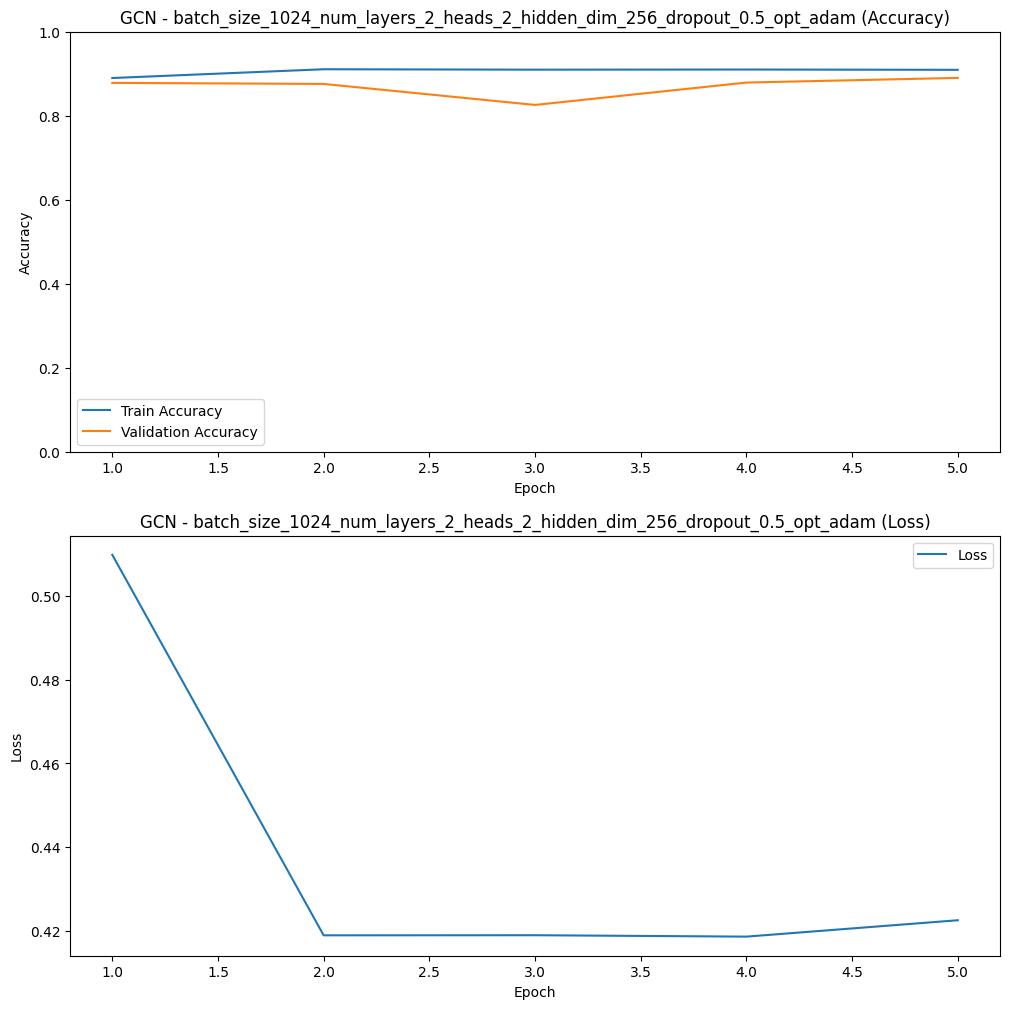

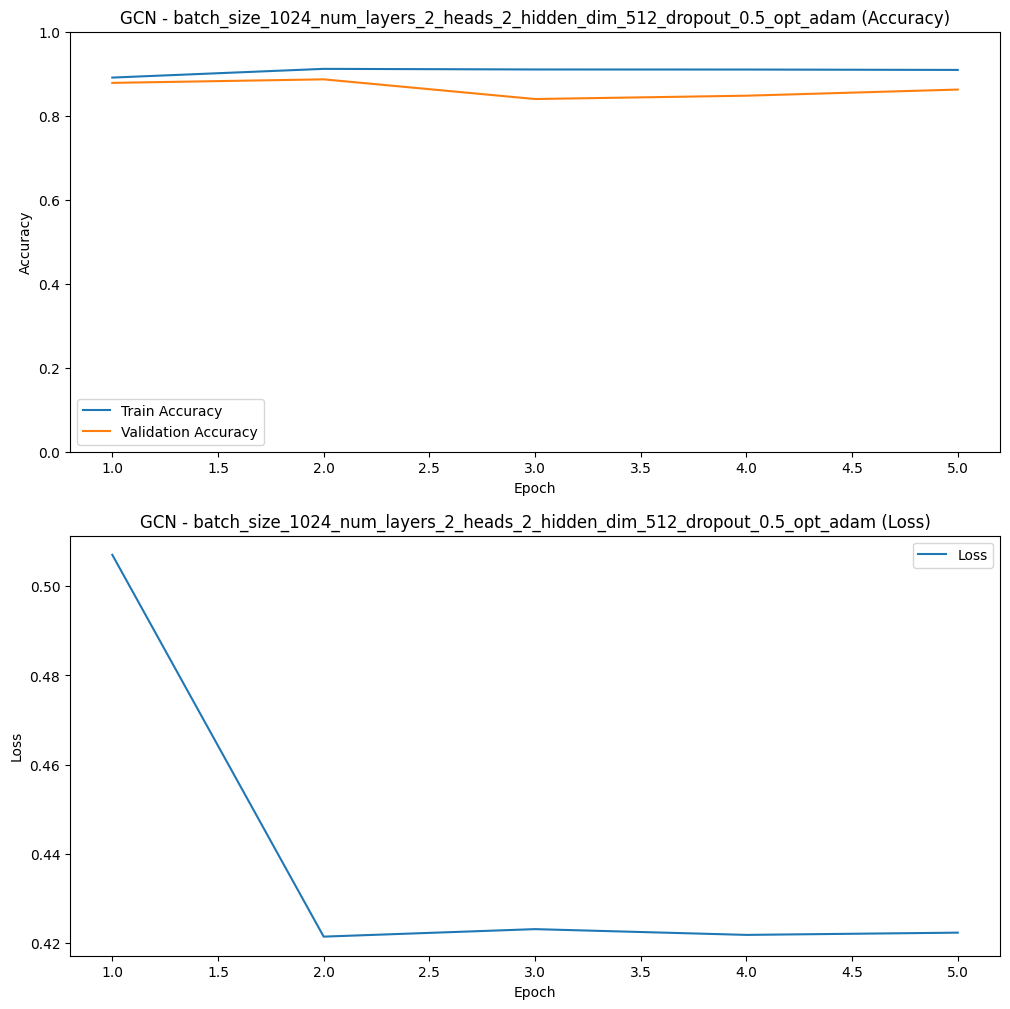

Epoch 01:   0%|          | 0/153431 [5:28:37<?, ?it/s]


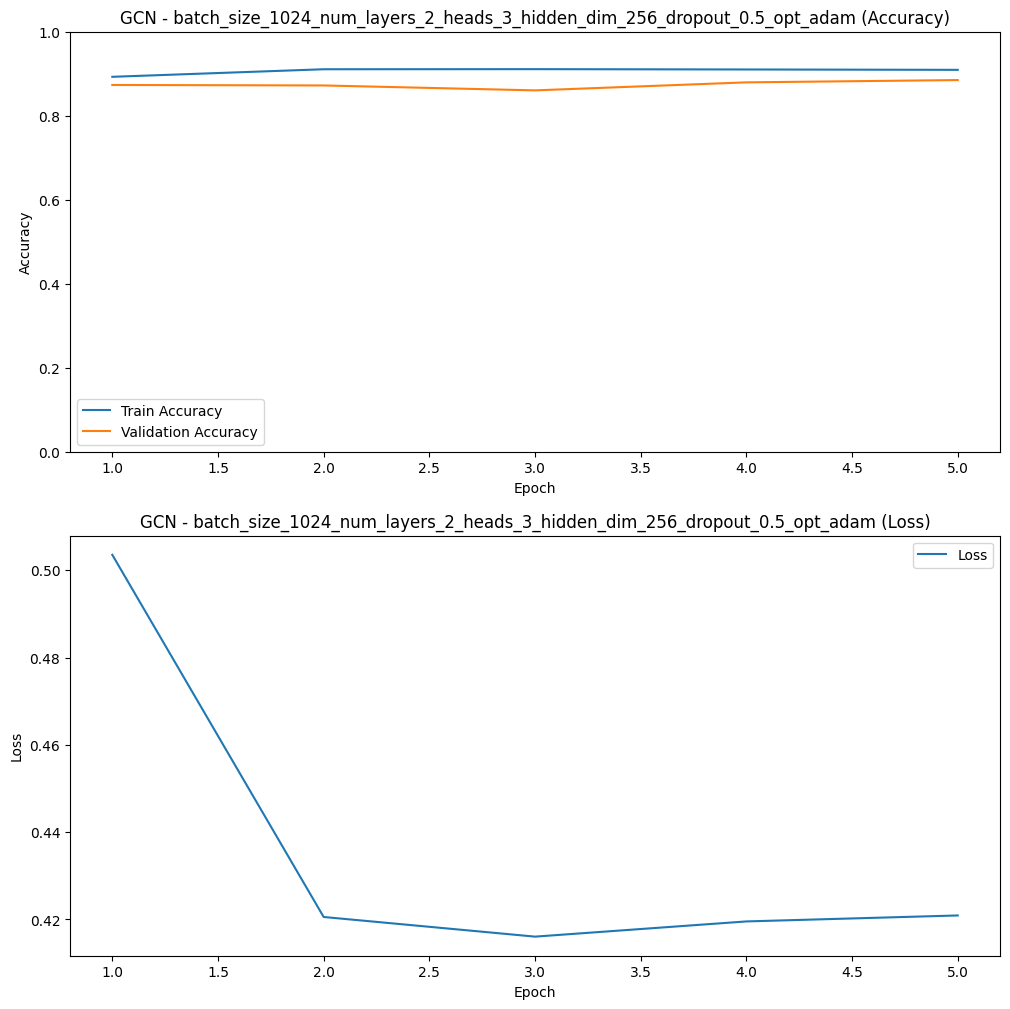

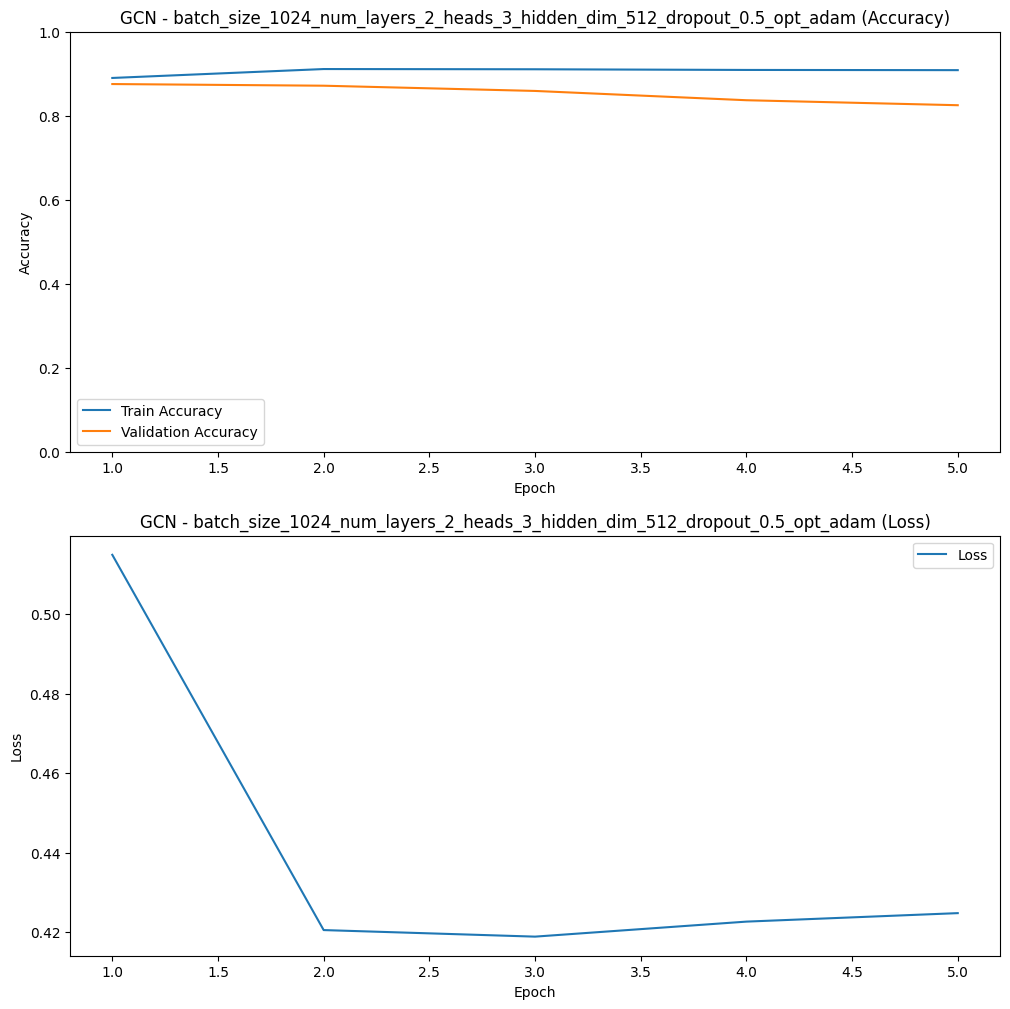

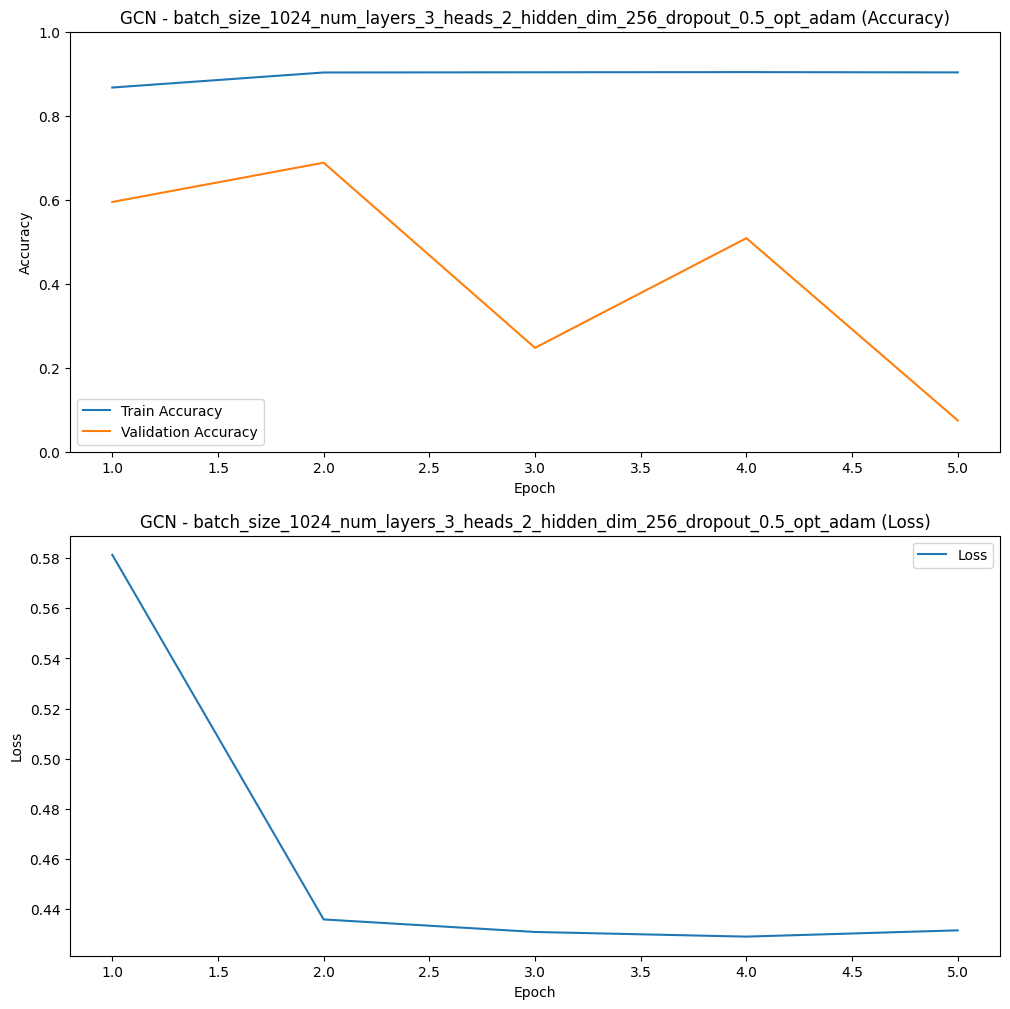

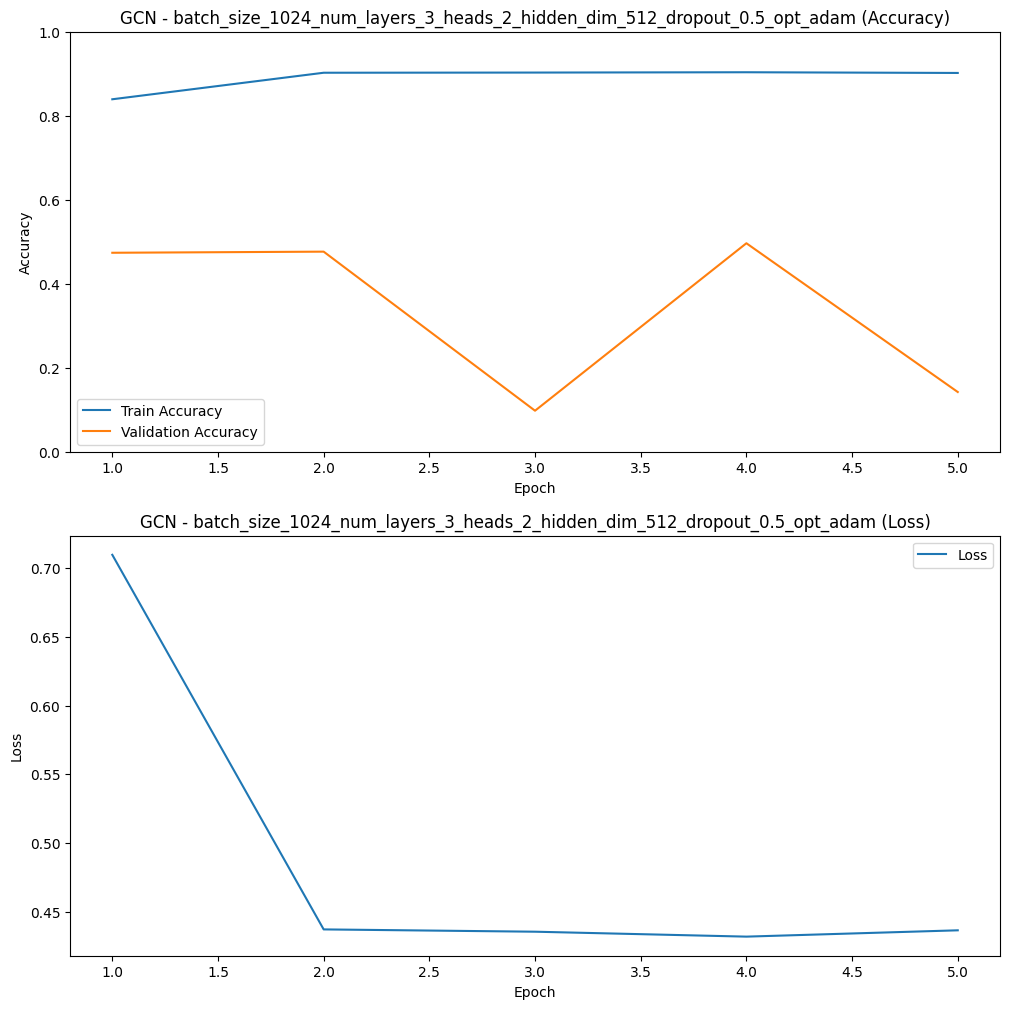

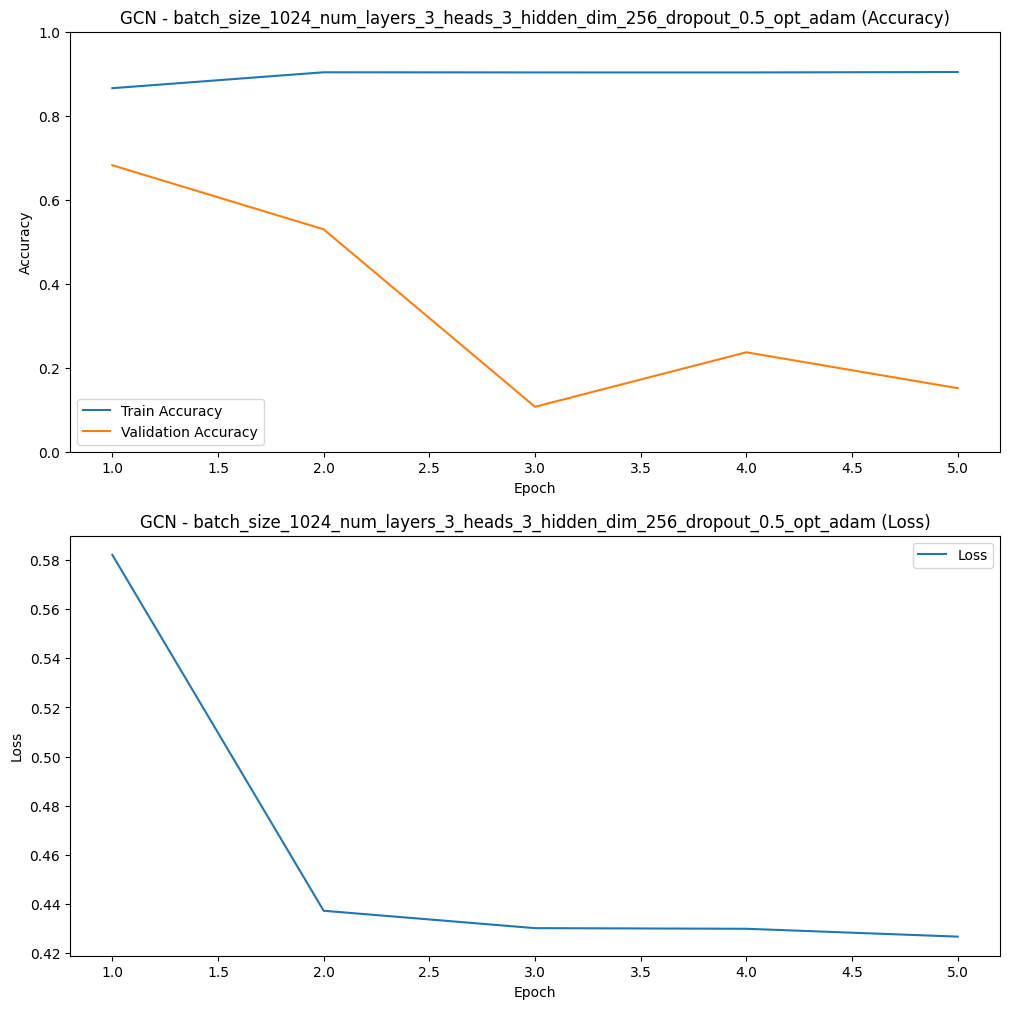

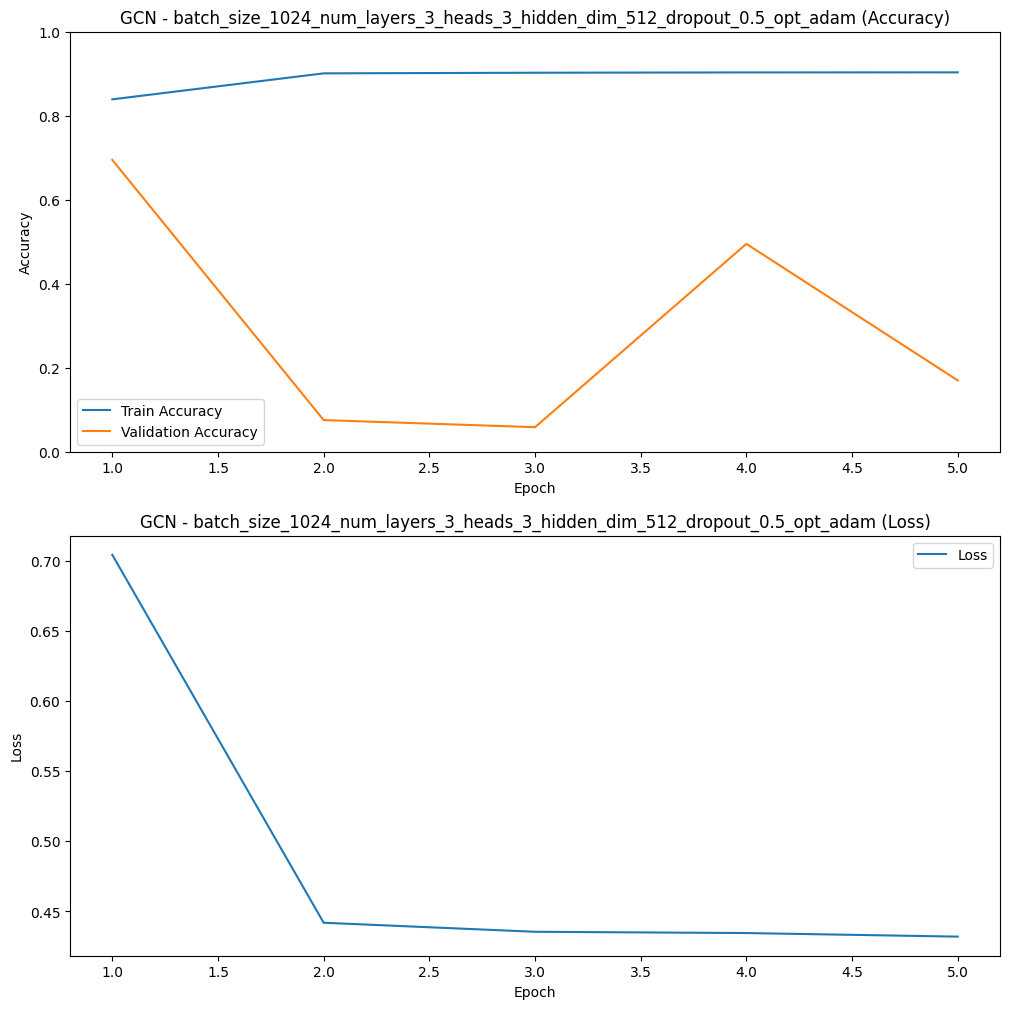

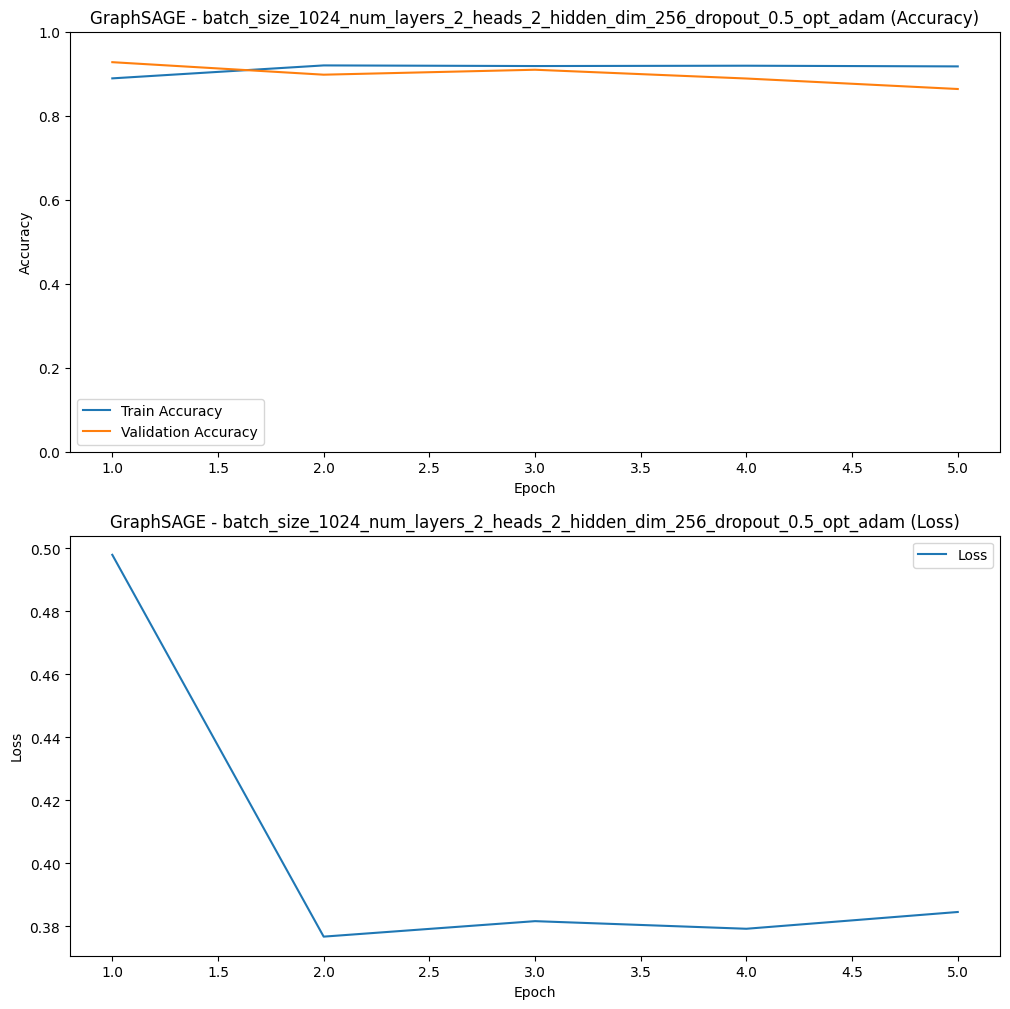

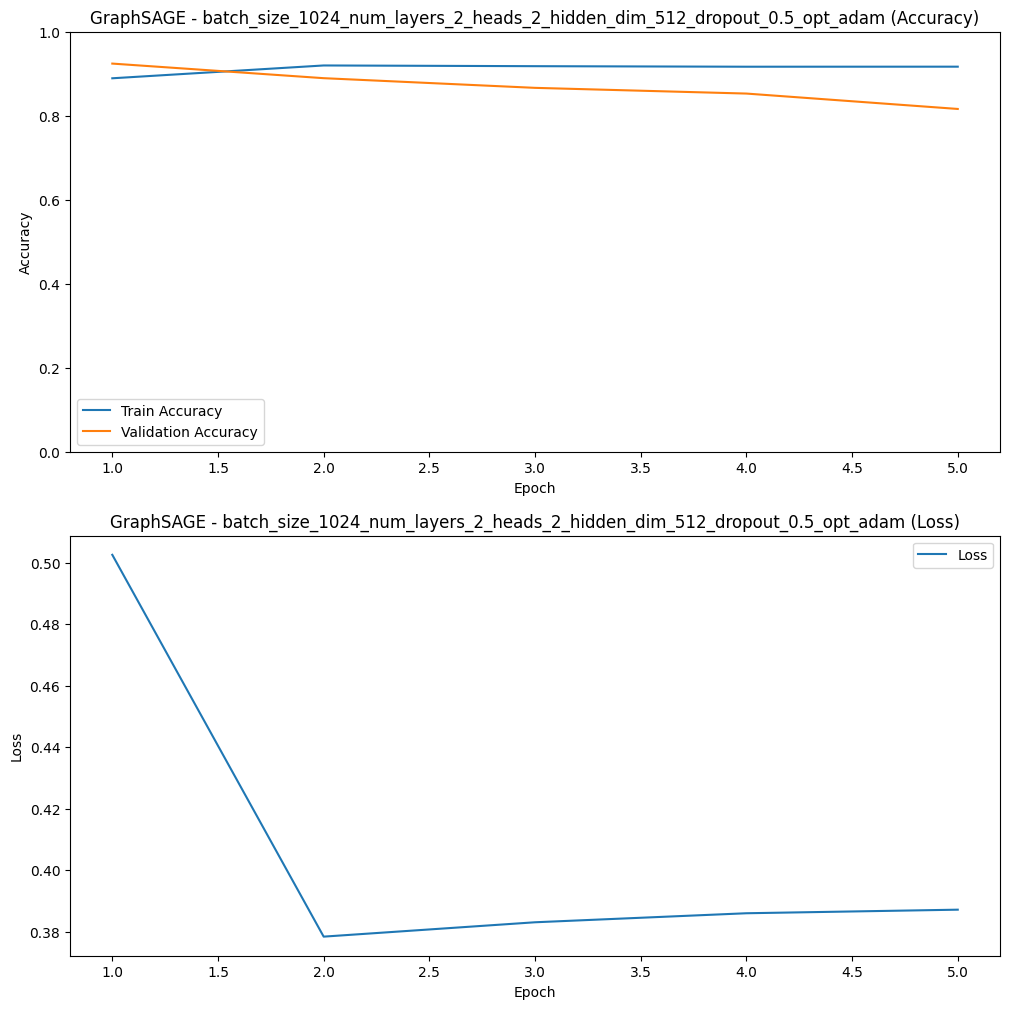

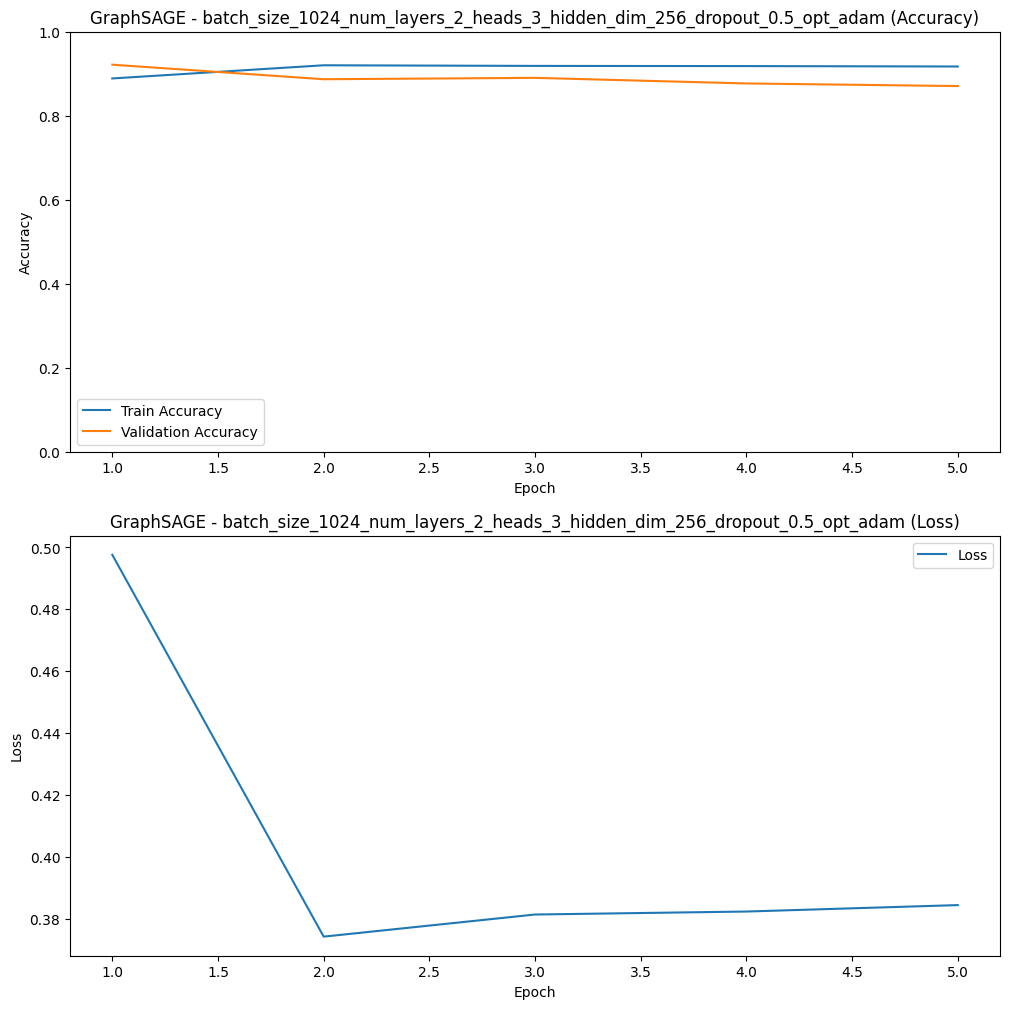

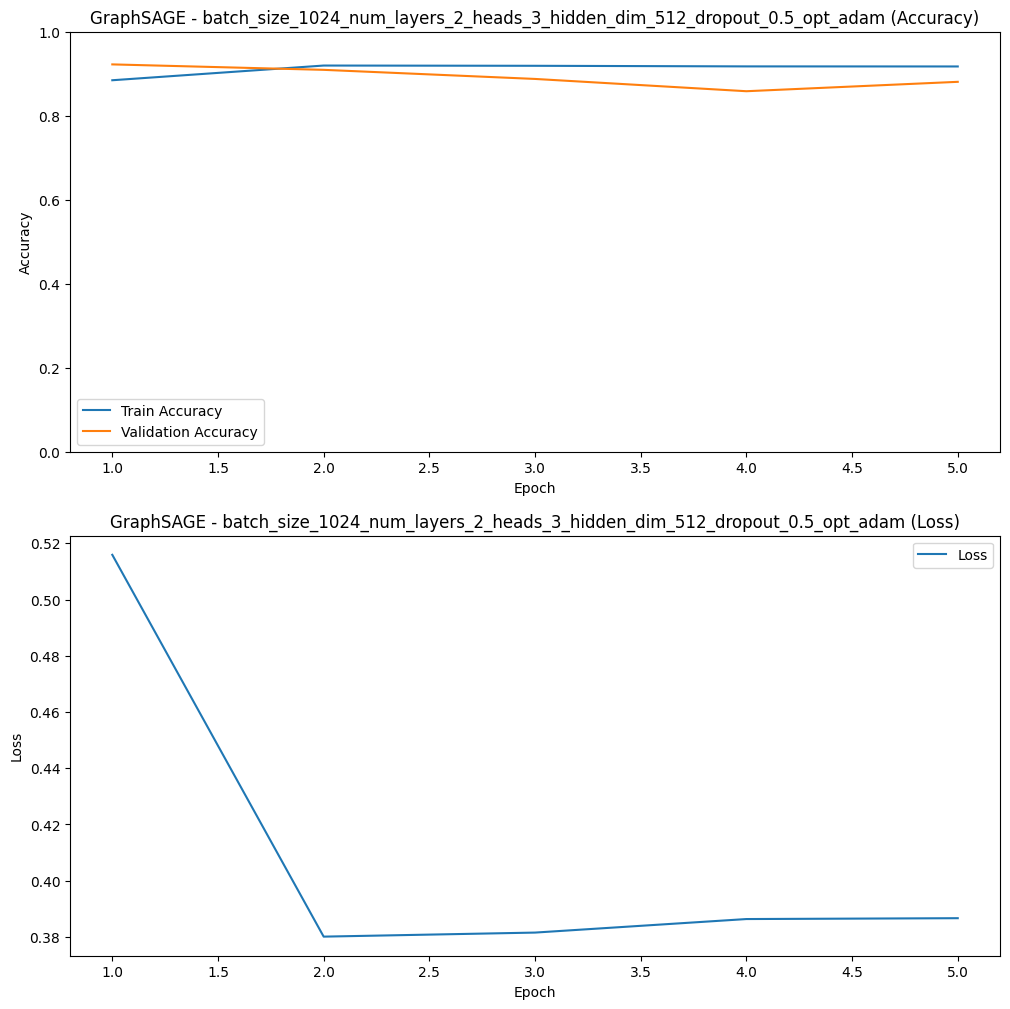

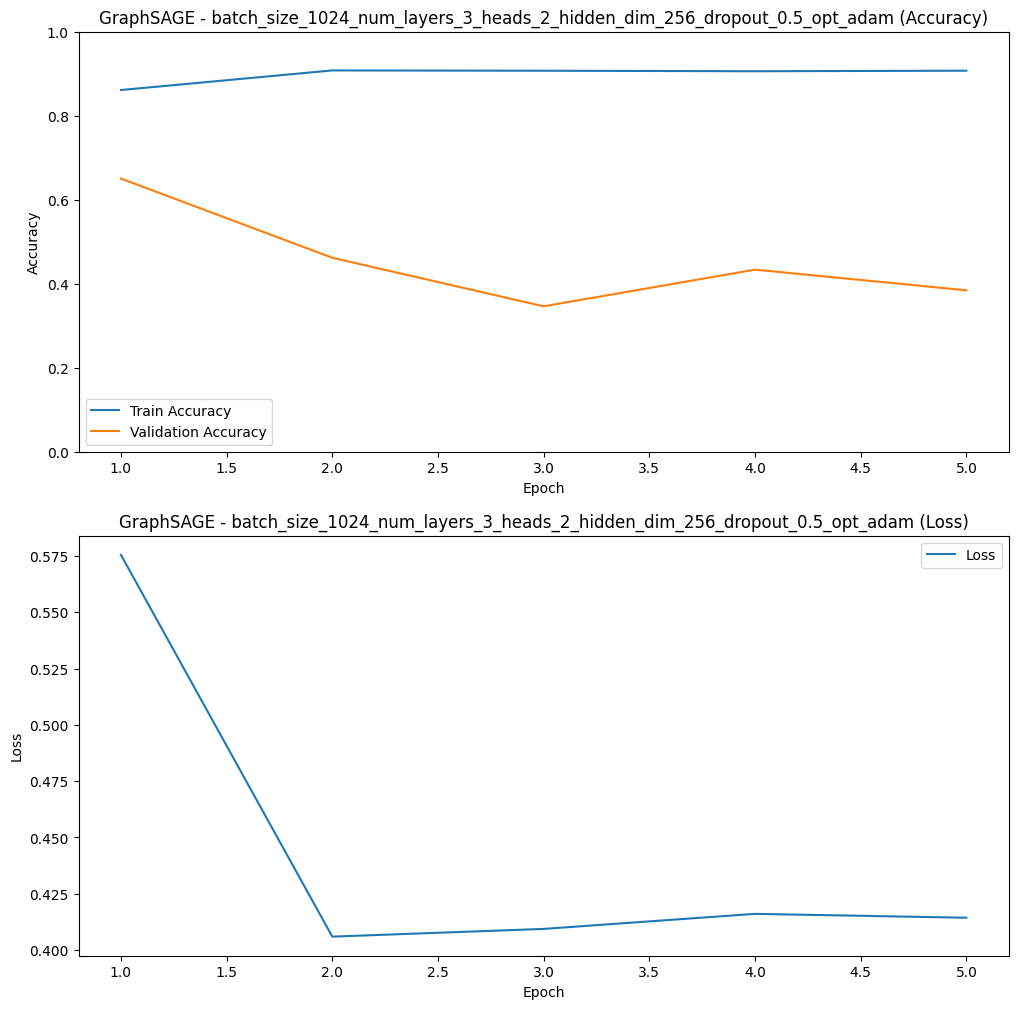

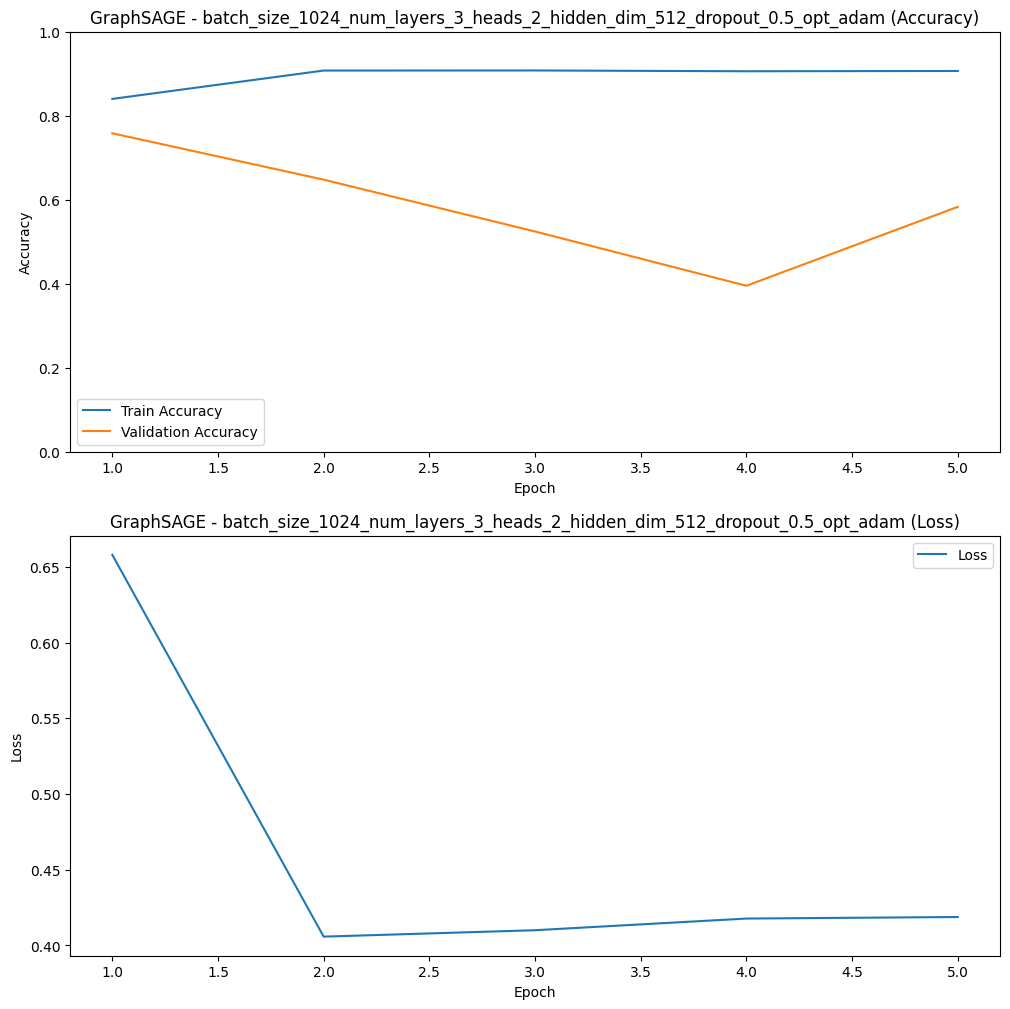

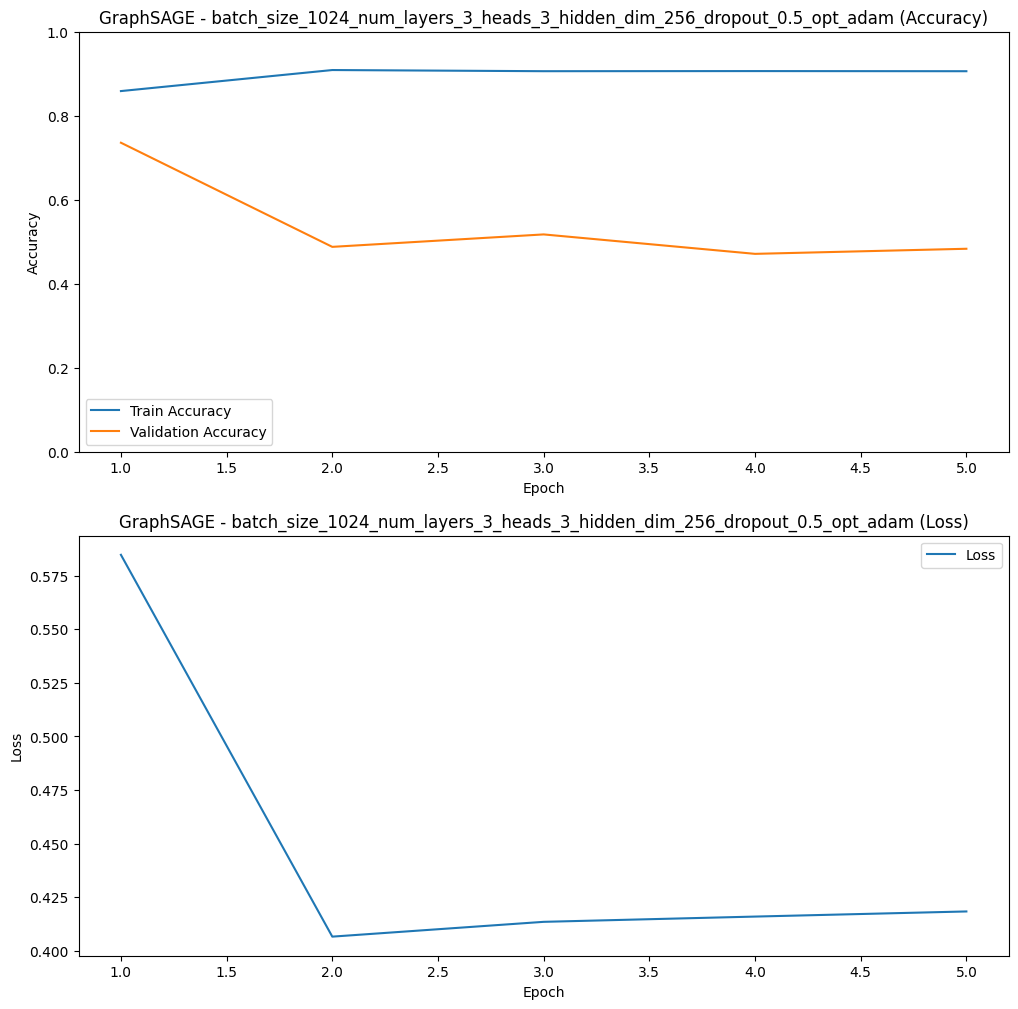

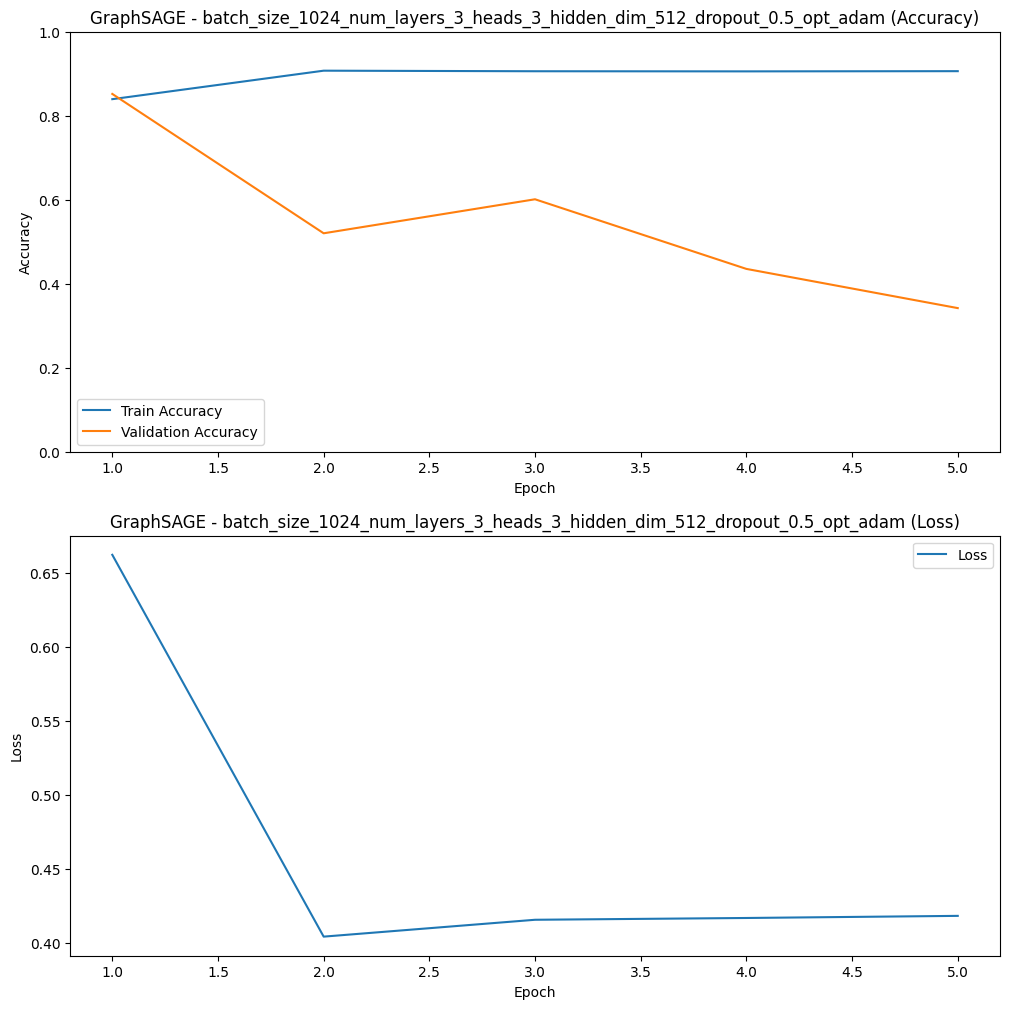

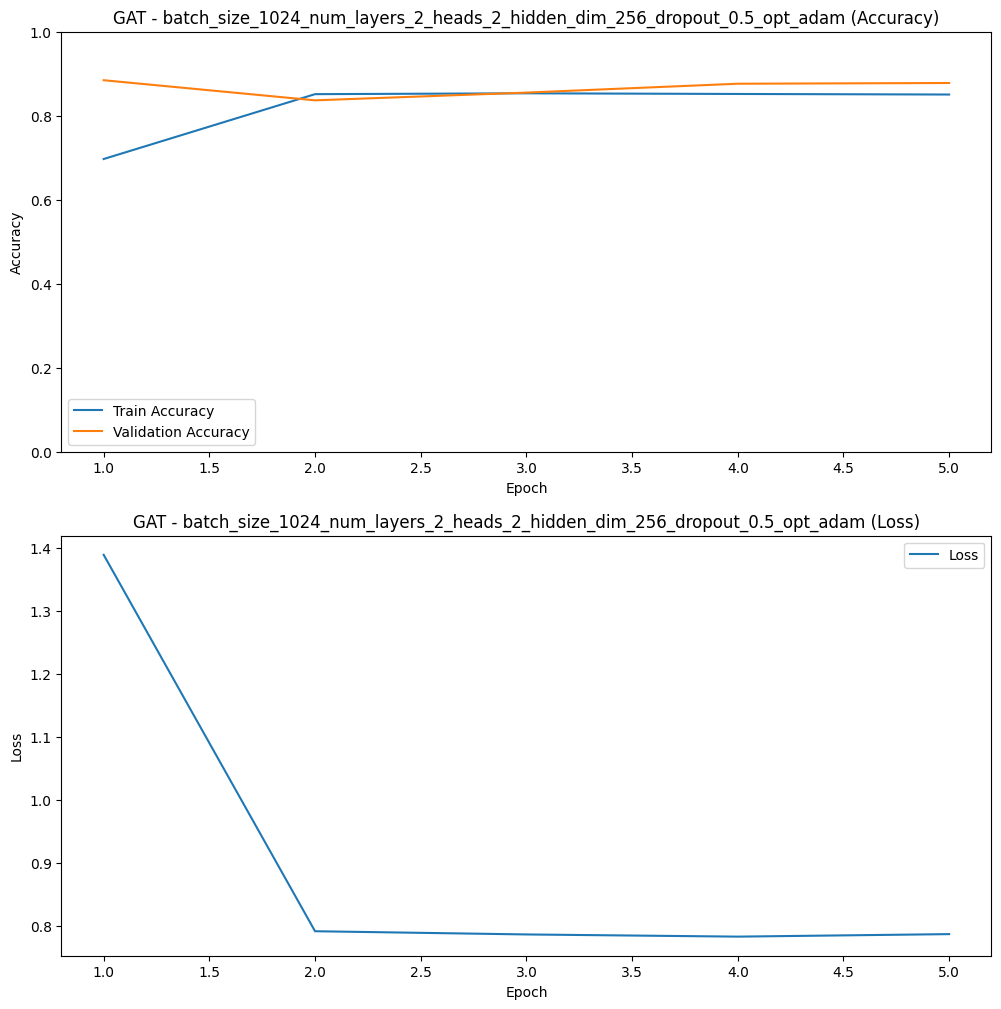

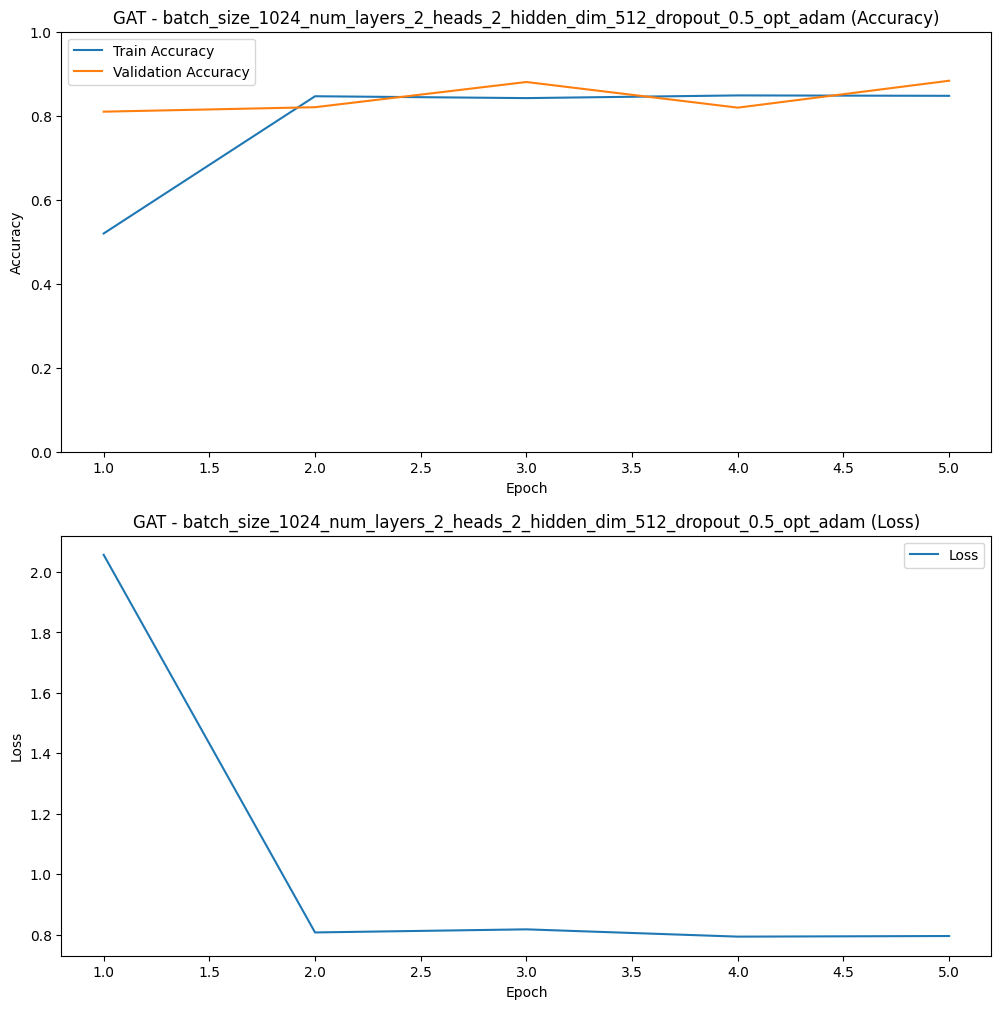

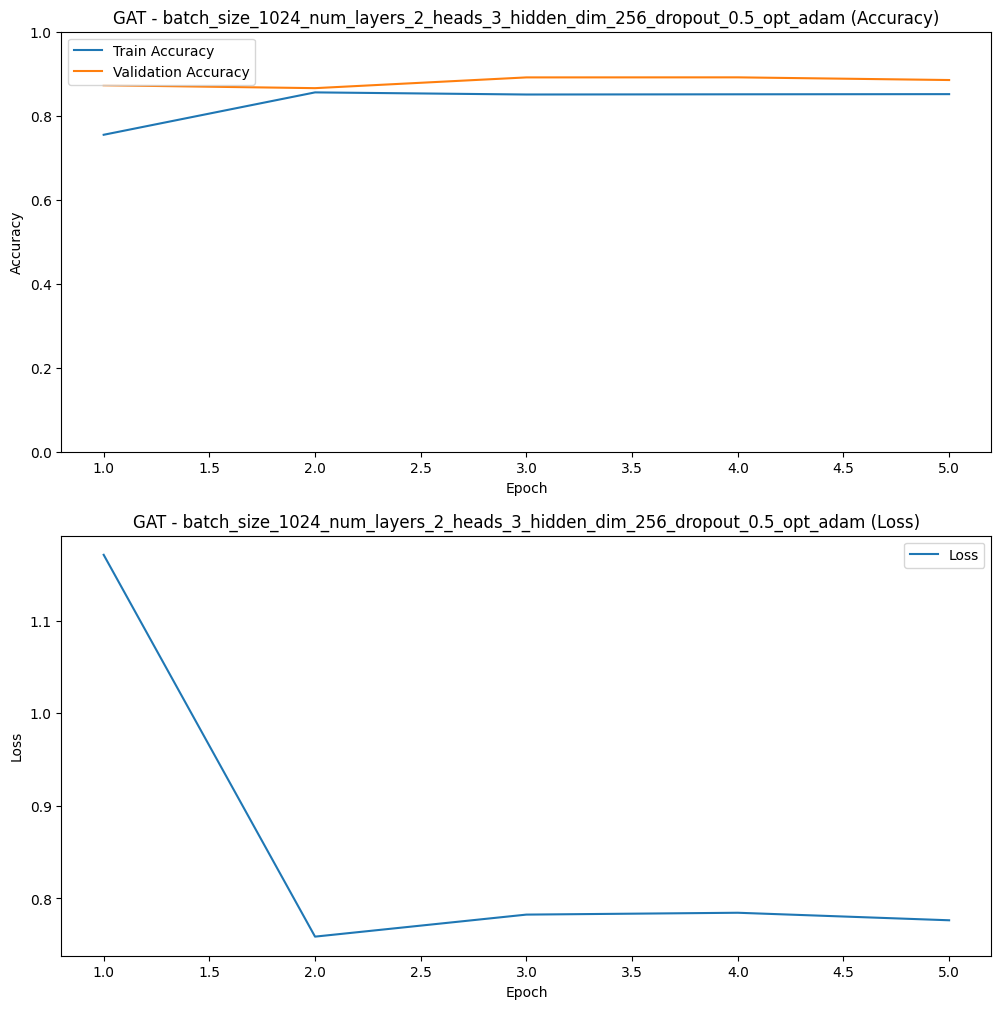

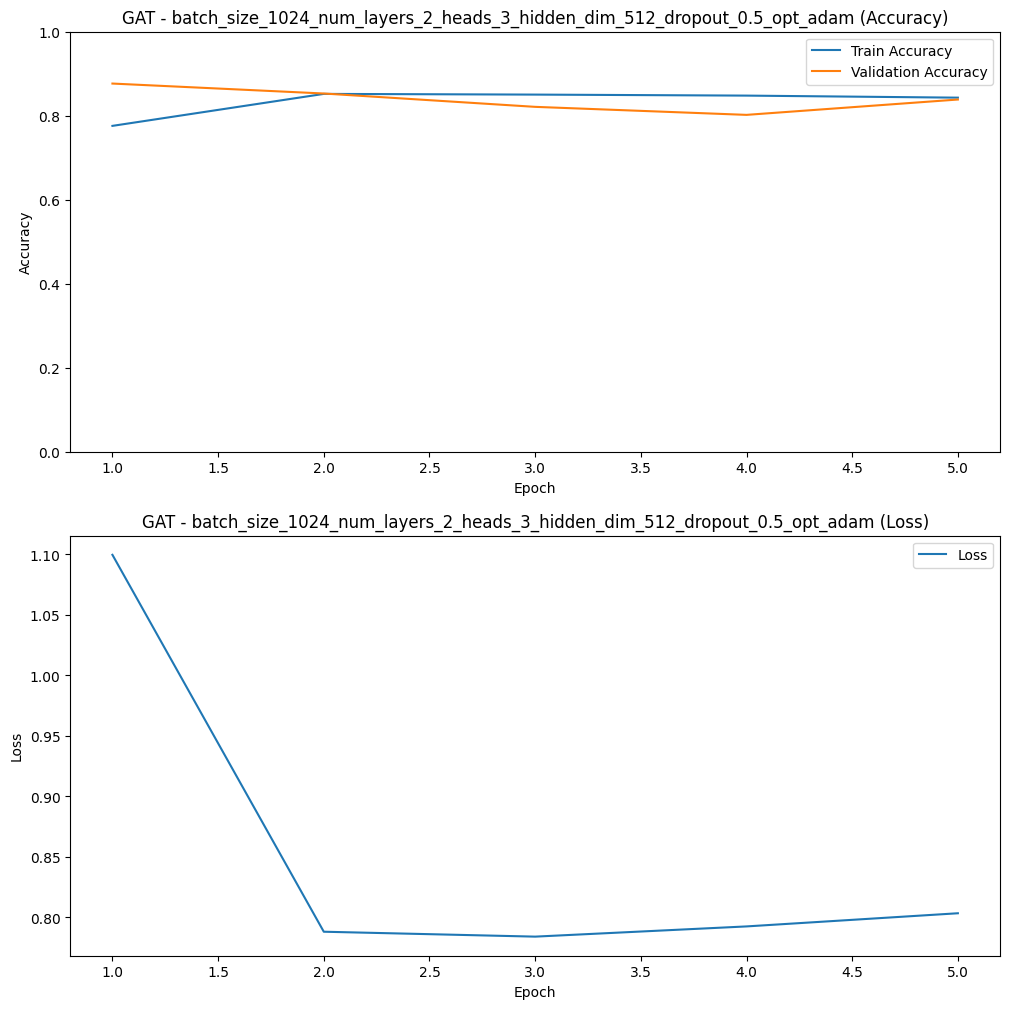

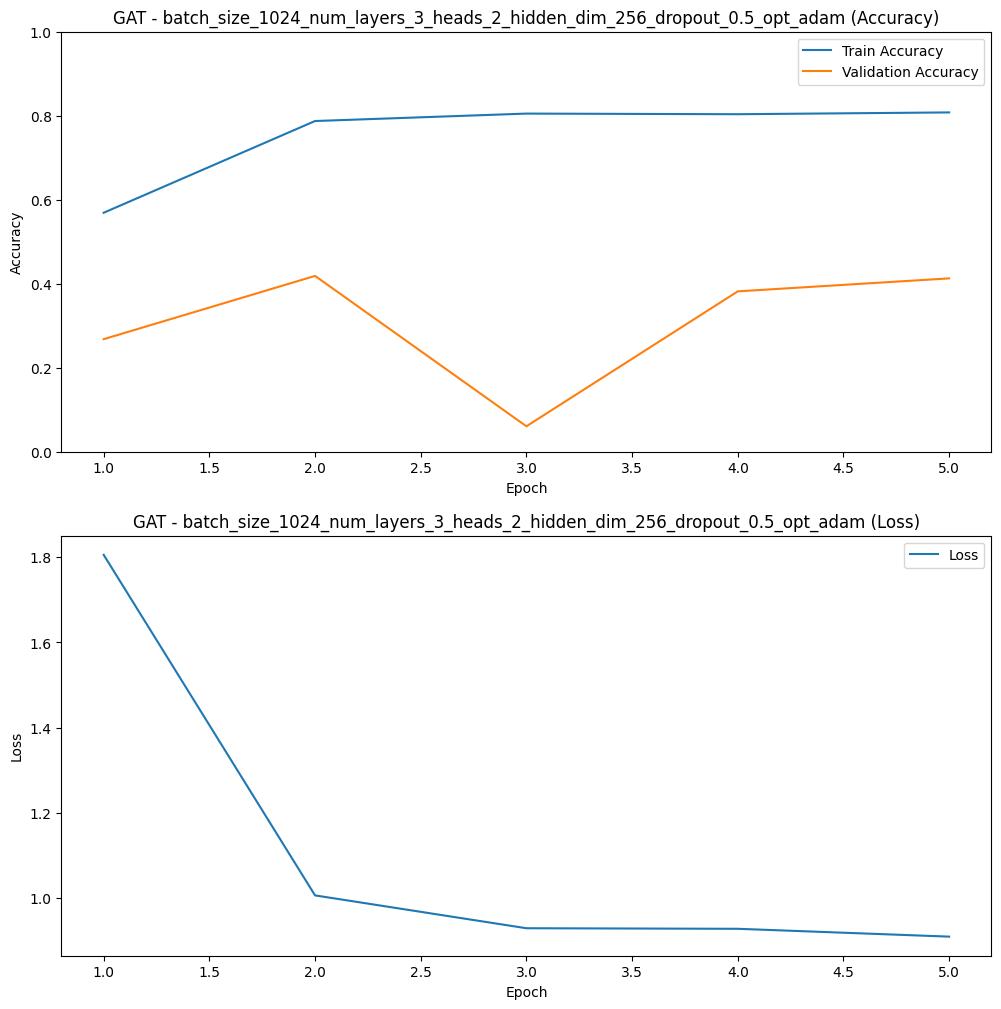

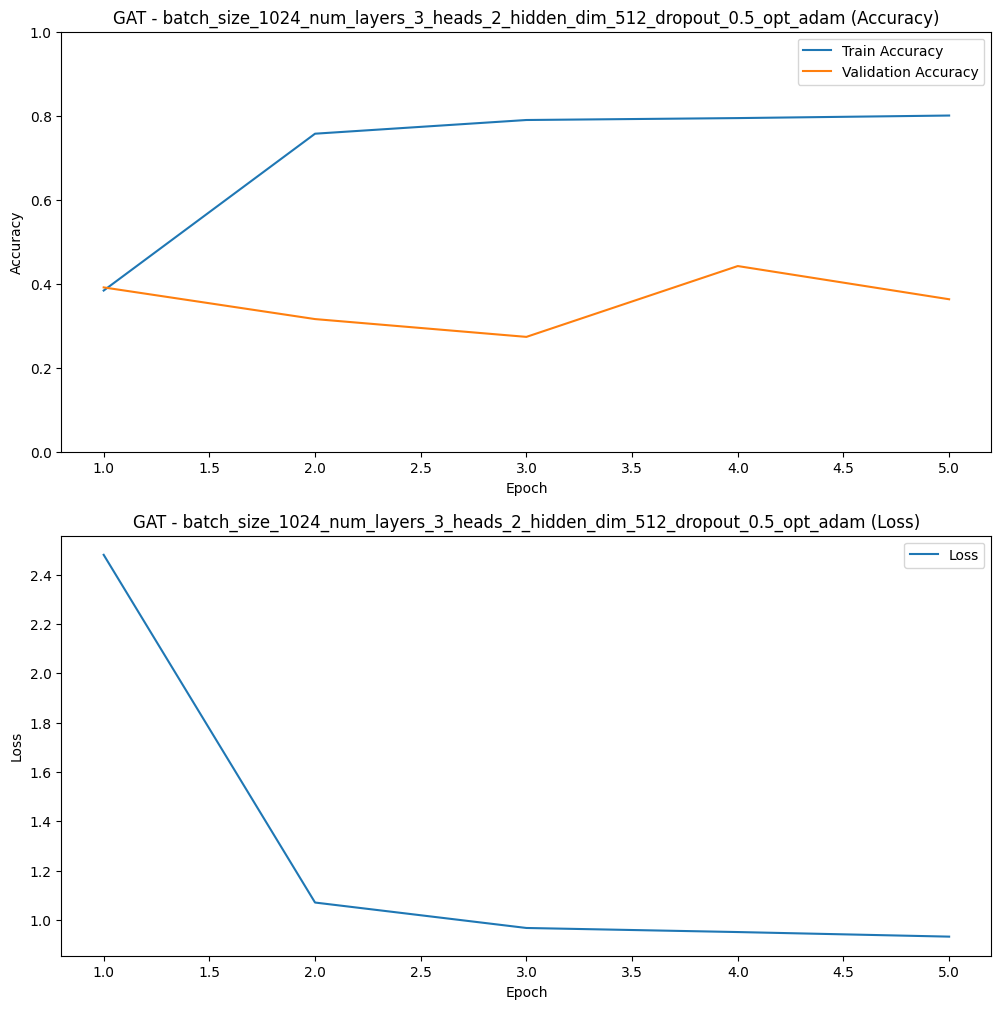

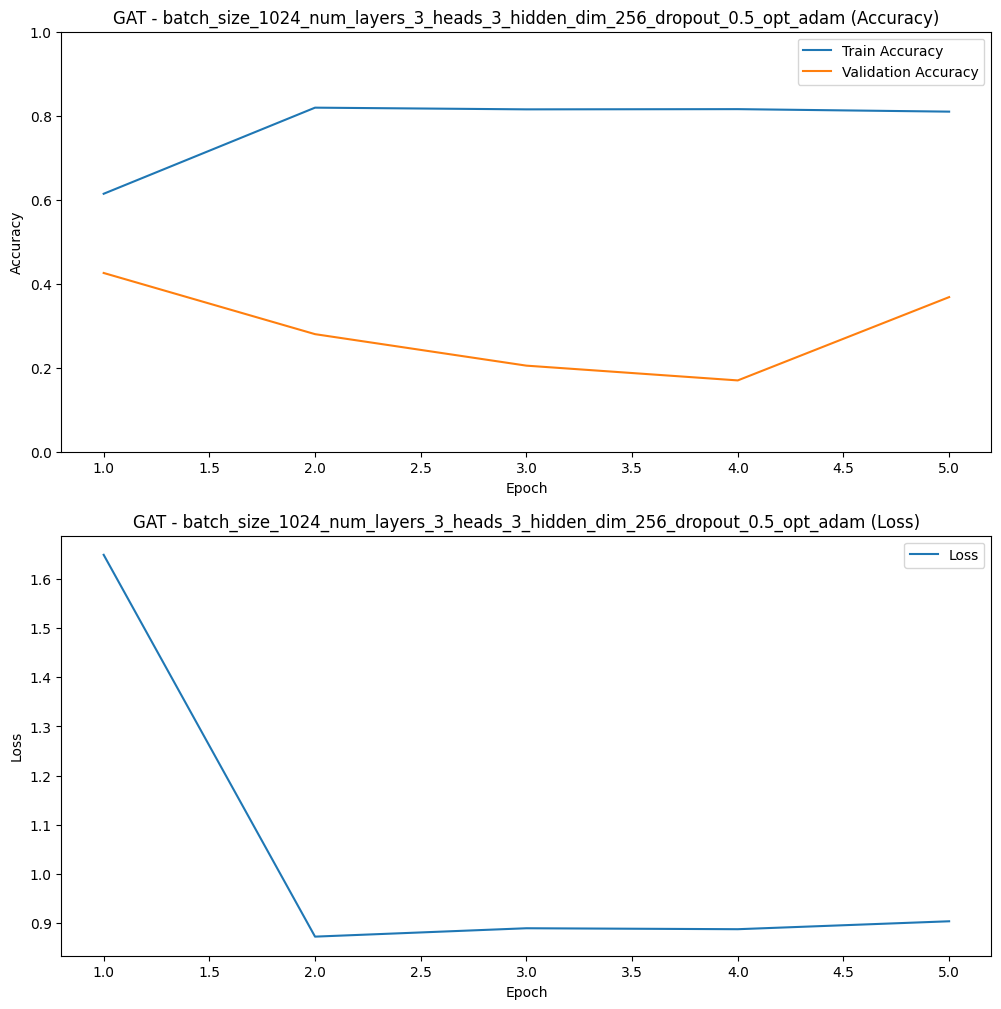

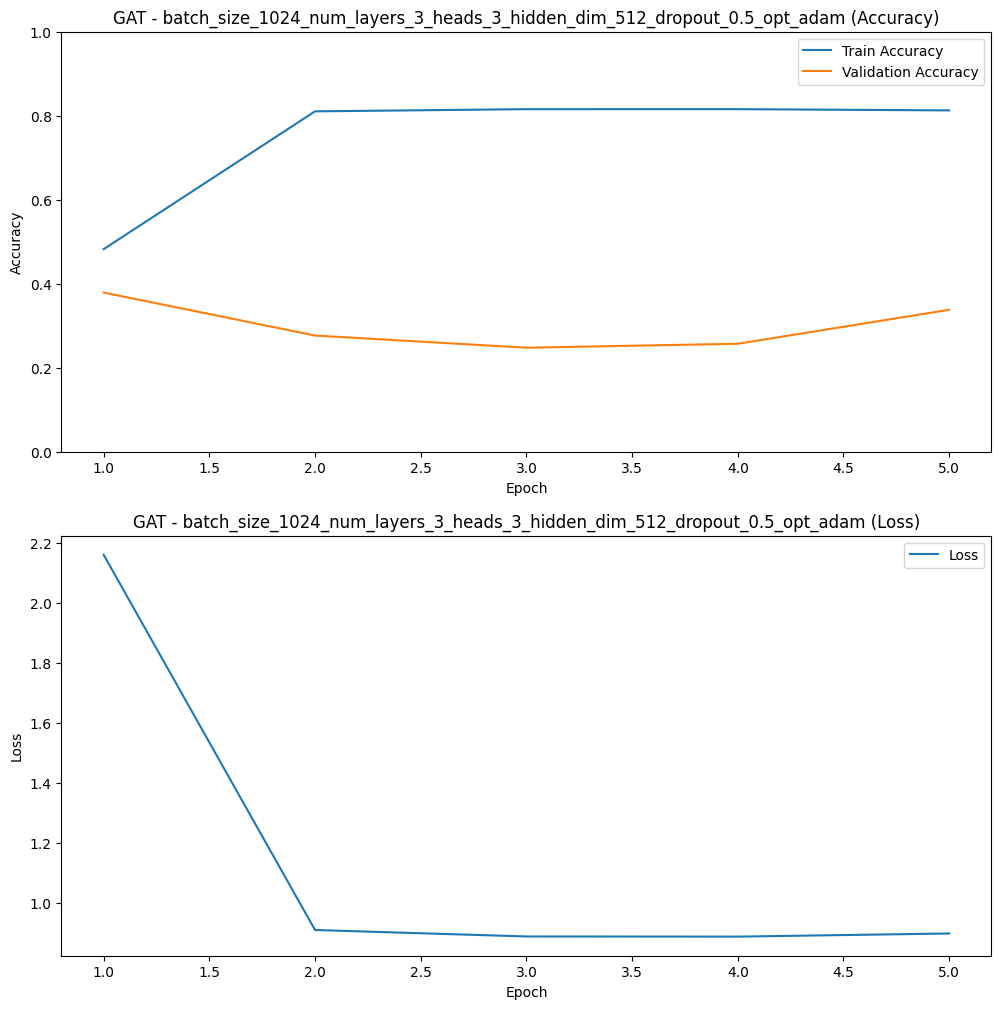

In [ ]:
plot_results(outputdf)

The analysis of the result data is explained in the report.